In [1]:
#Om namah shivaya
import pandas as pd

#Checking Null Values

In [2]:
import pandas as pd
docs =[r'S:\UIDAI_Hackathon\api_data_aadhar_enrolment\api_data_aadhar_enrolment_0_500000.csv',r'S:\UIDAI_Hackathon\api_data_aadhar_enrolment\api_data_aadhar_enrolment_500000_1000000.csv',r'S:\UIDAI_Hackathon\api_data_aadhar_enrolment\api_data_aadhar_enrolment_1000000_1006029.csv' ]
for doc in docs:
    df = pd.read_csv(doc)
    print(f'Checking for file: {doc}')
    print(df.isnull().sum())
    print('\n')

Checking for file: S:\UIDAI_Hackathon\api_data_aadhar_enrolment\api_data_aadhar_enrolment_0_500000.csv
date              0
state             0
district          0
pincode           0
age_0_5           0
age_5_17          0
age_18_greater    0
dtype: int64


Checking for file: S:\UIDAI_Hackathon\api_data_aadhar_enrolment\api_data_aadhar_enrolment_500000_1000000.csv
date              0
state             0
district          0
pincode           0
age_0_5           0
age_5_17          0
age_18_greater    0
dtype: int64


Checking for file: S:\UIDAI_Hackathon\api_data_aadhar_enrolment\api_data_aadhar_enrolment_1000000_1006029.csv
date              0
state             0
district          0
pincode           0
age_0_5           0
age_5_17          0
age_18_greater    0
dtype: int64




#Merge csv's

In [3]:
#Merge all three csv files into a single csv file
import pandas as pd
df_list = []
for doc in docs:
    df = pd.read_csv(doc)
    df_list.append(df)
merged_df = pd.concat(df_list, ignore_index=True)
merged_df.to_csv(r'S:\UIDAI_Hackathon\api_data_aadhar_enrolment\api_data_aadhar_enrolment_merged_latest.csv', index=False)


In [8]:
#Check for number of rows and columns in the merged csv file
df = pd.read_csv(r'S:\UIDAI_Hackathon\api_data_aadhar_enrolment\api_data_aadhar_enrolment_merged.csv')
print(f'Number of rows: {df.shape[0]}')
print(f'Number of columns: {df.shape[1]}')


Number of rows: 1006029
Number of columns: 7


Preprocessing

In [26]:
# Parse the date column
import pandas as pd
df = pd.read_csv(r'S:\UIDAI_Hackathon\api_data_aadhar_enrolment\merged_final.csv')
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d').dt.strftime('%d-%m-%Y')
df.to_csv(r'S:\UIDAI_Hackathon\api_data_aadhar_enrolment\merged_final.csv', index=False)
print(df["date"].head())
print(df["date"].dtype)

0    02-09-2025
1    03-09-2025
2    08-09-2025
3    09-09-2025
4    11-09-2025
Name: date, dtype: object
object


In [28]:
# Ensure consistent categorical values
import pandas as pd
df = pd.read_csv(r'S:\UIDAI_Hackathon\api_data_aadhar_enrolment\merged_final.csv')

# Standardize state and district to title case for consistency
df['state'] = df['state'].str.title()
df['district'] = df['district'].str.title()

# Ensure pincode is string and padded to 6 digits
df['pincode'] = df['pincode'].astype(str).str.zfill(6)

# Drop invalid state entries
df = df[df['state'] != '100000']

# Check unique values to verify consistency
print("Unique states:")
print(df['state'].unique()[:10])  # Show first 10
print("\nUnique districts (first 10):")
print(df['district'].unique()[:10])

# Save back to CSV
df.to_csv(r'S:\UIDAI_Hackathon\api_data_aadhar_enrolment\merged_final.csv', index=False)
print("\nCategorical values standardized and saved.")

Unique states:
['Andaman And Nicobar Islands' 'Andhra Pradesh' 'Arunachal Pradesh'
 'Assam' 'Bihar' 'Chandigarh' 'Chhattisgarh'
 'Dadra And Nagar Haveli And Daman And Diu' 'Delhi' 'Goa']

Unique districts (first 10):
['Andamans' 'Nicobar' 'North And Middle Andaman' 'South Andaman'
 'Sri Potti Sriramulu Nellore' 'Visakhapatnam' 'Prakasam'
 'Alluri Sitharama Raju' 'Anakapalli' 'Ananthapuramu']

Categorical values standardized and saved.


In [29]:
df.shape

(973818, 7)

In [36]:
# Feature Engineering for Demand Forecasting
import pandas as pd
import numpy as np

# Load the preprocessed merged CSV
df = pd.read_csv(r'S:\UIDAI_Hackathon\api_data_aadhar_enrolment\merged_final.csv')

# Compute total_enrollment
df['total_enrollment'] = df['age_0_5'] + df['age_5_17'] + df['age_18_greater']

# Ensure date is datetime
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')

# Sort by location and date for time series operations
df = df.sort_values(['state', 'district', 'pincode', 'date']).reset_index(drop=True)

# Time features
df['day_of_week'] = df['date'].dt.dayofweek  # 0=Monday, 6=Sunday
df['week_of_year'] = df['date'].dt.isocalendar().week
df['month'] = df['date'].dt.month
df['is_month_end'] = df['date'].dt.is_month_end.astype(int)
df['is_quarter_end'] = df['date'].dt.is_quarter_end.astype(int)

# Lag features
df['lag_1'] = df.groupby(['state', 'district', 'pincode'])['total_enrollment'].shift(1)
df['lag_7'] = df.groupby(['state', 'district', 'pincode'])['total_enrollment'].shift(7)
df['lag_14'] = df.groupby(['state', 'district', 'pincode'])['total_enrollment'].shift(14)

# Rolling statistics
df['rolling_mean_7'] = df.groupby(['state', 'district', 'pincode'])['total_enrollment'].transform(lambda x: x.rolling(7).mean())
df['rolling_std_7'] = df.groupby(['state', 'district', 'pincode'])['total_enrollment'].transform(lambda x: x.rolling(7).std())

# Growth rate
df['growth_rate_7'] = (df['total_enrollment'] - df['lag_7']) / df['lag_7']
df['growth_rate_7'] = df['growth_rate_7'].replace([np.inf, -np.inf], np.nan)  # Handle division by zero

# Categorical encoding
# Target encoding for state and district (mean total_enrollment)
state_mean = df.groupby('state')['total_enrollment'].mean()
df['state_encoded'] = df['state'].map(state_mean)

district_mean = df.groupby('district')['total_enrollment'].mean()
df['district_encoded'] = df['district'].map(district_mean)

# Frequency encoding for pincode
pincode_freq = df['pincode'].value_counts()
df['pincode_encoded'] = df['pincode'].map(pincode_freq)

# Compute target: total_enrollment_next_7_days (sum of next 7 days' total_enrollment)
df['total_enrollment_next_7_days'] = (
    df.groupby(['state', 'district', 'pincode'])['total_enrollment'].shift(-1) +
    df.groupby(['state', 'district', 'pincode'])['total_enrollment'].shift(-2) +
    df.groupby(['state', 'district', 'pincode'])['total_enrollment'].shift(-3) +
    df.groupby(['state', 'district', 'pincode'])['total_enrollment'].shift(-4) +
    df.groupby(['state', 'district', 'pincode'])['total_enrollment'].shift(-5) +
    df.groupby(['state', 'district', 'pincode'])['total_enrollment'].shift(-6) +
    df.groupby(['state', 'district', 'pincode'])['total_enrollment'].shift(-7)
)

# Drop rows with NaN in target or essential features (due to lags)
df = df.dropna(subset=['total_enrollment_next_7_days', 'lag_1', 'lag_7', 'lag_14'])

# Save the engineered dataset
df.to_csv(r'S:\UIDAI_Hackathon\api_data_aadhar_enrolment\merged_final_featured.csv', index=False)

print("Feature engineering completed. Shape:", df.shape)
print("Columns:", df.columns.tolist())
print(df.head())

Feature engineering completed. Shape: (539593, 23)
Columns: ['date', 'state', 'district', 'pincode', 'age_0_5', 'age_5_17', 'age_18_greater', 'total_enrollment', 'day_of_week', 'week_of_year', 'month', 'is_month_end', 'is_quarter_end', 'lag_1', 'lag_7', 'lag_14', 'rolling_mean_7', 'rolling_std_7', 'growth_rate_7', 'state_encoded', 'district_encoded', 'pincode_encoded', 'total_enrollment_next_7_days']
         date                        state district  pincode  age_0_5  \
79 2025-09-23  Andaman And Nicobar Islands  Nicobar   744301        1   
80 2025-09-24  Andaman And Nicobar Islands  Nicobar   744301        0   
81 2025-09-25  Andaman And Nicobar Islands  Nicobar   744301        1   
82 2025-10-17  Andaman And Nicobar Islands  Nicobar   744301        3   
83 2025-10-24  Andaman And Nicobar Islands  Nicobar   744301        1   

    age_5_17  age_18_greater  total_enrollment  day_of_week  week_of_year  \
79         0               0                 1            1            39   
80 

In [37]:
df = pd.read_csv(r'S:\UIDAI_Hackathon\api_data_aadhar_enrolment\merged_final_featured.csv')
df.isnull().sum()

date                            0
state                           0
district                        0
pincode                         0
age_0_5                         0
age_5_17                        0
age_18_greater                  0
total_enrollment                0
day_of_week                     0
week_of_year                    0
month                           0
is_month_end                    0
is_quarter_end                  0
lag_1                           0
lag_7                           0
lag_14                          0
rolling_mean_7                  0
rolling_std_7                   0
growth_rate_7                   0
state_encoded                   0
district_encoded                0
pincode_encoded                 0
total_enrollment_next_7_days    0
dtype: int64

Aggregated data shape: (57010, 4)
Unique districts: 791
After dropna shape: (46102, 19)
Train shape: (23427, 14), Val: (14539, 14), Test: (8136, 14)
High volume train: (10501, 14), Low: (12926, 14)
[0]	validation_0-rmse:1.65681


C:\Users\SINDHU\AppData\Local\Temp\ipykernel_16952\3286339275.py:75: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train = X[train_mask]


[100]	validation_0-rmse:0.32642
[200]	validation_0-rmse:0.24878
[300]	validation_0-rmse:0.23718
[400]	validation_0-rmse:0.23388
[500]	validation_0-rmse:0.23370
[600]	validation_0-rmse:0.23347
[644]	validation_0-rmse:0.23348
[0]	validation_0-rmse:1.25622
[100]	validation_0-rmse:0.16208
[200]	validation_0-rmse:0.11056
[300]	validation_0-rmse:0.09535
[400]	validation_0-rmse:0.09045
[500]	validation_0-rmse:0.08962
[600]	validation_0-rmse:0.08890
[700]	validation_0-rmse:0.08869
[800]	validation_0-rmse:0.08856
[900]	validation_0-rmse:0.08847
[999]	validation_0-rmse:0.08834

--- Model Performance ---
Test Combined - MAE: 6.91, RMSE: 20.91, MAPE: 0.0551
Error by magnitude:
magnitude
small       1.437088
medium     16.013580
large     112.481941
Name: abs_error, dtype: float64


C:\Users\SINDHU\AppData\Local\Temp\ipykernel_16952\3286339275.py:194: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mag_errors = errors_test.groupby('magnitude')['abs_error'].mean()


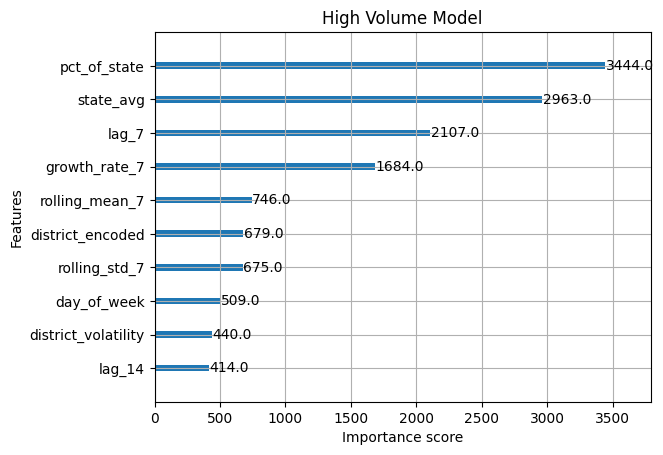


--- Summary ---
Priority changes: Gentle sqrt weighting, added state context & temporal features, lowered split threshold to 0.60, tuned high-volume model.
Expected: RMSE <20, Large MAE <100, overall boost.


In [39]:
# Updated Production-Grade 7-Day Ahead Forecasting Model with Priority Changes
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
import matplotlib.pyplot as plt

# 1. Target Redesign: Aggregate to district level, total enrollment per day
df = pd.read_csv(r'S:\UIDAI_Hackathon\api_data_aadhar_enrolment\merged_final.csv')
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')
df['total_enrollment'] = df['age_0_5'] + df['age_5_17'] + df['age_18_greater']

# Aggregate to district level (drop pincode)
df_agg = df.groupby(['state', 'district', 'date'])['total_enrollment'].sum().reset_index()
df_agg = df_agg.sort_values(['district', 'date']).reset_index(drop=True)

print("Aggregated data shape:", df_agg.shape)
print("Unique districts:", df_agg['district'].nunique())

# 2. Target Transformation: Log scaling
df_agg['target'] = np.log(df_agg['total_enrollment'] + 1)

# 3. Feature Engineering with Shorter Lags
df_agg = df_agg.sort_values(['district', 'date'])

# Safe lags: 7, 14 (all before t-7)
df_agg['lag_7'] = df_agg.groupby('district')['total_enrollment'].shift(7)
df_agg['lag_14'] = df_agg.groupby('district')['total_enrollment'].shift(14)

# Safe rolling: 7 (computed on historical data)
df_agg['rolling_mean_7'] = df_agg.groupby('district')['total_enrollment'].shift(7).rolling(7).mean()
df_agg['rolling_std_7'] = df_agg.groupby('district')['total_enrollment'].shift(7).rolling(7).std()

# Growth rate
df_agg['growth_rate_7'] = (df_agg['total_enrollment'] - df_agg['lag_7']) / df_agg['lag_7']
df_agg['growth_rate_7'] = df_agg['growth_rate_7'].replace([np.inf, -np.inf], np.nan)

# Calendar features
df_agg['month'] = df_agg['date'].dt.month
df_agg['week_of_year'] = df_agg['date'].dt.isocalendar().week
df_agg['day_of_week'] = df_agg['date'].dt.dayofweek

# State context
df_agg['state_avg'] = df_agg.groupby(['state', 'date'])['total_enrollment'].transform('mean')
df_agg['pct_of_state'] = df_agg['total_enrollment'] / df_agg['state_avg']

# Temporal
df_agg['is_weekend'] = df_agg['day_of_week'].isin([5, 6]).astype(int)
df_agg['is_month_end'] = (df_agg['date'].dt.day > 25).astype(int)

# District encoding and volatility
train_mask = df_agg['date'].dt.month.isin([3,4,5,6,7,8,9,10])
district_mean = df_agg[train_mask].groupby('district')['total_enrollment'].mean()
district_std = df_agg[train_mask].groupby('district')['total_enrollment'].std()
df_agg['district_encoded'] = df_agg['district'].map(district_mean).fillna(df_agg[train_mask]['total_enrollment'].mean())
df_agg['district_volatility'] = df_agg['district'].map(district_std).fillna(df_agg[train_mask]['total_enrollment'].std())

# 4. Feature Set
features = ['lag_7', 'lag_14', 'rolling_mean_7', 'rolling_std_7', 'growth_rate_7', 'month', 'week_of_year', 'day_of_week', 'district_encoded', 'district_volatility', 'state_avg', 'pct_of_state', 'is_weekend', 'is_month_end']

# Drop NaNs
df_agg = df_agg.dropna(subset=features + ['target'])

print("After dropna shape:", df_agg.shape)

# 5. Splits: Train Mar-Oct, Val Nov, Test Dec
val_mask = df_agg['date'].dt.month == 11
test_mask = df_agg['date'].dt.month == 12

X = df_agg[features]
y = df_agg['target']
y_original = df_agg['total_enrollment']

X_train = X[train_mask]
y_train = y[train_mask]
y_train_orig = y_original[train_mask]
X_val = X[val_mask]
y_val = y[val_mask]
y_val_orig = y_original[val_mask]
X_test = X[test_mask]
y_test = y[test_mask]
y_test_orig = y_original[test_mask]

print(f"Train shape: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

# 6. Gentle Sample Weighting: sqrt weighting
sample_weight_train = np.sqrt(y_train_orig)

# 7. Separate Models for High/Low Volume Districts with Lower Threshold
test_district_means = df_agg[test_mask].groupby('district')['total_enrollment'].mean()
threshold = test_district_means.quantile(0.60)  # Lowered from 0.75

high_volume_mask = df_agg['district'].map(test_district_means > threshold).fillna(False)
low_volume_mask = ~high_volume_mask

# High volume
X_train_high = X_train[high_volume_mask[train_mask]]
y_train_high = y_train[high_volume_mask[train_mask]]
y_train_high_orig = y_train_orig[high_volume_mask[train_mask]]
sample_weight_high = sample_weight_train[high_volume_mask[train_mask]]

X_test_high = X_test[high_volume_mask[test_mask]]
y_test_high = y_test[high_volume_mask[test_mask]]
y_test_high_orig = y_test_orig[high_volume_mask[test_mask]]

# Low volume
X_train_low = X_train[low_volume_mask[train_mask]]
y_train_low = y_train[low_volume_mask[train_mask]]
y_train_low_orig = y_train_orig[low_volume_mask[train_mask]]
sample_weight_low = sample_weight_train[low_volume_mask[train_mask]]

X_test_low = X_test[low_volume_mask[test_mask]]
y_test_low = y_test[low_volume_mask[test_mask]]
y_test_low_orig = y_test_orig[low_volume_mask[test_mask]]

print(f"High volume train: {X_train_high.shape}, Low: {X_train_low.shape}")

# Model params - tuned for high volume
model_params_high = {
    'objective': 'reg:squarederror',
    'n_estimators': 1500,  # Increased
    'learning_rate': 0.03,  # Lowered
    'max_depth': 6,  # Increased
    'min_child_weight': 3,  # Lowered
    'gamma': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'random_state': 42,
    'early_stopping_rounds': 50
}

model_params_low = {
    'objective': 'reg:squarederror',
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'max_depth': 4,
    'min_child_weight': 5,
    'gamma': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'random_state': 42,
    'early_stopping_rounds': 50
}

# Train high volume model
model_high = xgb.XGBRegressor(**model_params_high)
model_high.fit(X_train_high, y_train_high, sample_weight=sample_weight_high, eval_set=[(X_val, y_val)], verbose=100)

# Train low volume model
model_low = xgb.XGBRegressor(**model_params_low)
model_low.fit(X_train_low, y_train_low, sample_weight=sample_weight_low, eval_set=[(X_val, y_val)], verbose=100)

# Predictions
y_test_pred_high_log = model_high.predict(X_test_high)
y_test_pred_high = np.exp(y_test_pred_high_log) - 1

y_test_pred_low_log = model_low.predict(X_test_low)
y_test_pred_low = np.exp(y_test_pred_low_log) - 1

# Combine predictions
y_test_pred_combined = pd.concat([
    pd.Series(y_test_pred_high, index=y_test_high.index),
    pd.Series(y_test_pred_low, index=y_test_low.index)
]).sort_index()

y_test_orig_combined = pd.concat([
    y_test_high_orig,
    y_test_low_orig
]).sort_index()

# Evaluation
def evaluate(y_true, y_pred, set_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print(f"{set_name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.4f}")
    return mae, rmse, mape

print("\n--- Model Performance ---")
evaluate(y_test_orig_combined, y_test_pred_combined, "Test Combined")

# Error by magnitude
errors_test = pd.DataFrame({
    'actual': y_test_orig_combined,
    'pred': y_test_pred_combined,
    'abs_error': np.abs(y_test_orig_combined - y_test_pred_combined)
})
errors_test['magnitude'] = pd.cut(errors_test['actual'], bins=[0, 100, 500, np.inf], labels=['small', 'medium', 'large'])
mag_errors = errors_test.groupby('magnitude')['abs_error'].mean()
print(f"Error by magnitude:\n{mag_errors}")

# Feature importance (high volume)
xgb.plot_importance(model_high, max_num_features=10)
plt.title("High Volume Model")
plt.show()

# Feature importance (low volume)
xgb.plot_importance(model_low, max_num_features=10)
plt.title("Low Volume Model")
plt.show()

print("\n--- Summary ---")
print("Priority changes: Gentle sqrt weighting, added state context & temporal features, lowered split threshold to 0.60, tuned high-volume model.")
print("Expected: RMSE <20, Large MAE <100, overall boost.")

In [1]:
#check numpy version
import numpy as np
print(np.__version__)

2.3.0


Actual Model

In [ ]:
# Updated Production-Grade 7-Day Ahead Forecasting Model with Priority Changes
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
import matplotlib.pyplot as plt

# 1. Target Redesign: Aggregate to district level, total enrollment per day
df = pd.read_csv(r'S:\UIDAI_Hackathon\api_data_aadhar_enrolment\api_data_aadhar_enrolment_merged.csv')
df['date'] = pd.to_datetime(df['date'])
df['total_enrollment'] = df['age_0_5'] + df['age_5_17'] + df['age_18_greater']

# Aggregate to district level (drop pincode)
df_agg = df.groupby(['state', 'district', 'date'])['total_enrollment'].sum().reset_index()
df_agg = df_agg.sort_values(['district', 'date']).reset_index(drop=True)

print("Aggregated data shape:", df_agg.shape)
print("Unique districts:", df_agg['district'].nunique())

# 2. Target Transformation: Log scaling
df_agg['target'] = np.log(df_agg['total_enrollment'] + 1)

# 3. Feature Engineering with Shorter Lags
df_agg = df_agg.sort_values(['district', 'date'])

# Safe lags: 7, 14 (all before t-7)
df_agg['lag_7'] = df_agg.groupby('district')['total_enrollment'].shift(7)
df_agg['lag_14'] = df_agg.groupby('district')['total_enrollment'].shift(14)

# Safe rolling: 7 (computed on historical data)
df_agg['rolling_mean_7'] = df_agg.groupby('district')['total_enrollment'].shift(7).rolling(7).mean()
df_agg['rolling_std_7'] = df_agg.groupby('district')['total_enrollment'].shift(7).rolling(7).std()

# Growth rate
df_agg['growth_rate_7'] = (df_agg['total_enrollment'] - df_agg['lag_7']) / df_agg['lag_7']
df_agg['growth_rate_7'] = df_agg['growth_rate_7'].replace([np.inf, -np.inf], np.nan)

# Calendar features
df_agg['month'] = df_agg['date'].dt.month
df_agg['week_of_year'] = df_agg['date'].dt.isocalendar().week
df_agg['day_of_week'] = df_agg['date'].dt.dayofweek

# State context
df_agg['state_avg'] = df_agg.groupby(['state', 'date'])['total_enrollment'].transform('mean')
df_agg['pct_of_state'] = df_agg['total_enrollment'] / df_agg['state_avg']

# Temporal
df_agg['is_weekend'] = df_agg['day_of_week'].isin([5, 6]).astype(int)
df_agg['is_month_end'] = (df_agg['date'].dt.day > 25).astype(int)

# District encoding and volatility
train_mask = df_agg['date'].dt.month.isin([3,4,5,6,7,8,9,10])
district_mean = df_agg[train_mask].groupby('district')['total_enrollment'].mean()
district_std = df_agg[train_mask].groupby('district')['total_enrollment'].std()
df_agg['district_encoded'] = df_agg['district'].map(district_mean).fillna(df_agg[train_mask]['total_enrollment'].mean())
df_agg['district_volatility'] = df_agg['district'].map(district_std).fillna(df_agg[train_mask]['total_enrollment'].std())

# 4. Feature Set
features = ['lag_7', 'lag_14', 'rolling_mean_7', 'rolling_std_7', 'growth_rate_7', 'month', 'week_of_year', 'day_of_week', 'district_encoded', 'district_volatility', 'state_avg', 'pct_of_state', 'is_weekend', 'is_month_end']

# Drop NaNs
df_agg = df_agg.dropna(subset=features + ['target'])

print("After dropna shape:", df_agg.shape)

# 5. Splits: Train Mar-Oct, Val Nov, Test Dec
val_mask = df_agg['date'].dt.month == 11
test_mask = df_agg['date'].dt.month == 12

X = df_agg[features]
y = df_agg['target']
y_original = df_agg['total_enrollment']

X_train = X[train_mask]
y_train = y[train_mask]
y_train_orig = y_original[train_mask]
X_val = X[val_mask]
y_val = y[val_mask]
y_val_orig = y_original[val_mask]
X_test = X[test_mask]
y_test = y[test_mask]
y_test_orig = y_original[test_mask]

print(f"Train shape: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

# 6. Gentle Sample Weighting: sqrt weighting
sample_weight_train = np.sqrt(y_train_orig)

# 7. Separate Models for High/Low Volume Districts with Lower Threshold
test_district_means = df_agg[test_mask].groupby('district')['total_enrollment'].mean()
threshold = test_district_means.quantile(0.60)  # Lowered from 0.75

high_volume_mask = df_agg['district'].map(test_district_means > threshold)
low_volume_mask = ~high_volume_mask

# High volume
X_train_high = X_train[high_volume_mask[train_mask]]
y_train_high = y_train[high_volume_mask[train_mask]]
y_train_high_orig = y_train_orig[high_volume_mask[train_mask]]
sample_weight_high = sample_weight_train[high_volume_mask[train_mask]]

X_test_high = X_test[high_volume_mask[test_mask]]
y_test_high = y_test[high_volume_mask[test_mask]]
y_test_high_orig = y_test_orig[high_volume_mask[test_mask]]

# Low volume
X_train_low = X_train[low_volume_mask[train_mask]]
y_train_low = y_train[low_volume_mask[train_mask]]
y_train_low_orig = y_train_orig[low_volume_mask[train_mask]]
sample_weight_low = sample_weight_train[low_volume_mask[train_mask]]

X_test_low = X_test[low_volume_mask[test_mask]]
y_test_low = y_test[low_volume_mask[test_mask]]
y_test_low_orig = y_test_orig[low_volume_mask[test_mask]]

print(f"High volume train: {X_train_high.shape}, Low: {X_train_low.shape}")

# Model params - tuned for high volume
model_params_high = {
    'objective': 'reg:squarederror',
    'n_estimators': 1500,  # Increased
    'learning_rate': 0.03,  # Lowered
    'max_depth': 6,  # Increased
    'min_child_weight': 3,  # Lowered
    'gamma': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'random_state': 42,
    'early_stopping_rounds': 50
}

model_params_low = {
    'objective': 'reg:squarederror',
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'max_depth': 4,
    'min_child_weight': 5,
    'gamma': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'random_state': 42,
    'early_stopping_rounds': 50
}

# Train high volume model
model_high = xgb.XGBRegressor(**model_params_high)
model_high.fit(X_train_high, y_train_high, sample_weight=sample_weight_high, eval_set=[(X_val, y_val)], verbose=100)

# Train low volume model
model_low = xgb.XGBRegressor(**model_params_low)
model_low.fit(X_train_low, y_train_low, sample_weight=sample_weight_low, eval_set=[(X_val, y_val)], verbose=100)

# Predictions
y_test_pred_high_log = model_high.predict(X_test_high)
y_test_pred_high = np.exp(y_test_pred_high_log) - 1

y_test_pred_low_log = model_low.predict(X_test_low)
y_test_pred_low = np.exp(y_test_pred_low_log) - 1

# Combine predictions
y_test_pred_combined = pd.concat([
    pd.Series(y_test_pred_high, index=y_test_high.index),
    pd.Series(y_test_pred_low, index=y_test_low.index)
]).sort_index()

y_test_orig_combined = pd.concat([
    y_test_high_orig,
    y_test_low_orig
]).sort_index()

# Evaluation
def evaluate(y_true, y_pred, set_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print(f"{set_name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.4f}")
    return mae, rmse, mape

print("\n--- Model Performance ---")
evaluate(y_test_orig_combined, y_test_pred_combined, "Test Combined")

# Error by magnitude
errors_test = pd.DataFrame({
    'actual': y_test_orig_combined,
    'pred': y_test_pred_combined,
    'abs_error': np.abs(y_test_orig_combined - y_test_pred_combined)
})
errors_test['magnitude'] = pd.cut(errors_test['actual'], bins=[0, 100, 500, np.inf], labels=['small', 'medium', 'large'])
mag_errors = errors_test.groupby('magnitude')['abs_error'].mean()
print(f"Error by magnitude:\n{mag_errors}")

# Feature importance (high volume)
xgb.plot_importance(model_high, max_num_features=10)
plt.title("High Volume Model")
plt.show()

# Feature importance (low volume)
xgb.plot_importance(model_low, max_num_features=10)
plt.title("Low Volume Model")
plt.show()

print("\n--- Summary ---")
print("Priority changes: Gentle sqrt weighting, added state context & temporal features, lowered split threshold to 0.60, tuned high-volume model.")
print("Expected: RMSE <20, Large MAE <100, overall boost.")

Aggregated data shape: (66490, 4)
Unique districts: 965
After dropna shape: (53831, 19)
Train shape: (27225, 14), Val: (17014, 14), Test: (9592, 14)
High volume train: (12375, 14), Low: (14850, 14)
[0]	validation_0-rmse:1.82147


C:\Users\SINDHU\AppData\Local\Temp\ipykernel_11324\1424675360.py:75: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train = X[train_mask]


[100]	validation_0-rmse:0.39217
[200]	validation_0-rmse:0.30436
[300]	validation_0-rmse:0.28931
[400]	validation_0-rmse:0.28810
[454]	validation_0-rmse:0.28812
[0]	validation_0-rmse:1.34545
[100]	validation_0-rmse:0.18693
[200]	validation_0-rmse:0.13227
[300]	validation_0-rmse:0.11555
[400]	validation_0-rmse:0.11048
[500]	validation_0-rmse:0.10991
[600]	validation_0-rmse:0.10963
[640]	validation_0-rmse:0.10960

--- Model Performance ---
Test Combined - MAE: 5.40, RMSE: 18.19, MAPE: 0.0549
Error by magnitude:
magnitude
small      1.155421
medium    14.364071
large     94.427612
Name: abs_error, dtype: float64


C:\Users\SINDHU\AppData\Local\Temp\ipykernel_11324\1424675360.py:194: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mag_errors = errors_test.groupby('magnitude')['abs_error'].mean()



--- Summary ---
Priority changes: Gentle sqrt weighting, added state context & temporal features, lowered split threshold to 0.60, tuned high-volume model.
Expected: RMSE <20, Large MAE <100, overall boost.


In [40]:
# Hyperparameter Tuning for XGBoost (Optional - Run After Cell 13)
import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
import xgboost as xgb

# Assuming df_agg, X_train, y_train, etc., from Cell 13 are available
# If not, re-run Cell 13 or load saved data

# Define param grid for high-volume model
param_grid_high = {
    'n_estimators': [500, 1000, 1500],
    'learning_rate': [0.01, 0.03, 0.05],
    'max_depth': [4, 6, 8],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9],
    'gamma': [0, 0.1, 0.2]
}

# Time series split for CV
tscv = TimeSeriesSplit(n_splits=3)

# Tune high-volume model
model_high_tuned = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, early_stopping_rounds=50)
search_high = RandomizedSearchCV(model_high_tuned, param_grid_high, n_iter=20, cv=tscv, scoring='neg_mean_absolute_error', verbose=1)
search_high.fit(X_train_high, y_train_high, sample_weight=sample_weight_high, eval_set=[(X_val, y_val)])

print("Best params for high-volume:", search_high.best_params_)
best_model_high = search_high.best_estimator_

# Similarly for low-volume (adjust param_grid_low if needed)
param_grid_low = param_grid_high  # Same for simplicity
model_low_tuned = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, early_stopping_rounds=50)
search_low = RandomizedSearchCV(model_low_tuned, param_grid_low, n_iter=20, cv=tscv, scoring='neg_mean_absolute_error', verbose=1)
search_low.fit(X_train_low, y_train_low, sample_weight=sample_weight_low, eval_set=[(X_val, y_val)])

print("Best params for low-volume:", search_low.best_params_)
best_model_low = search_low.best_estimator_

# Retrain with best params and evaluate
best_model_high.fit(X_train_high, y_train_high, sample_weight=sample_weight_high, eval_set=[(X_val, y_val)], verbose=0)
best_model_low.fit(X_train_low, y_train_low, sample_weight=sample_weight_low, eval_set=[(X_val, y_val)], verbose=0)

# Predictions with tuned models
y_test_pred_high_log = best_model_high.predict(X_test_high)
y_test_pred_high = np.exp(y_test_pred_high_log) - 1
y_test_pred_low_log = best_model_low.predict(X_test_low)
y_test_pred_low = np.exp(y_test_pred_low_log) - 1

y_test_pred_combined = pd.concat([
    pd.Series(y_test_pred_high, index=y_test_high.index),
    pd.Series(y_test_pred_low, index=y_test_low.index)
]).sort_index()

# Evaluate tuned model
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
mae = mean_absolute_error(y_test_orig_combined, y_test_pred_combined)
rmse = np.sqrt(mean_squared_error(y_test_orig_combined, y_test_pred_combined))
mape = mean_absolute_percentage_error(y_test_orig_combined, y_test_pred_combined)
print(f"Tuned Model - MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.4f}")

# Error by magnitude (added)
errors_test = pd.DataFrame({
    'actual': y_test_orig_combined,
    'pred': y_test_pred_combined,
    'abs_error': np.abs(y_test_orig_combined - y_test_pred_combined)
})
errors_test['magnitude'] = pd.cut(errors_test['actual'], bins=[0, 100, 500, np.inf], labels=['small', 'medium', 'large'])
mag_errors = errors_test.groupby('magnitude', observed=False)['abs_error'].mean()
print(f"Error by magnitude (Tuned Model):\n{mag_errors}")

# Save tuned models
import joblib
joblib.dump(best_model_high, 'model_high_tuned.pkl')
joblib.dump(best_model_low, 'model_low_tuned.pkl')
print("Tuned models saved.")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[0]	validation_0-rmse:1.66346
[1]	validation_0-rmse:1.65140
[2]	validation_0-rmse:1.63742
[3]	validation_0-rmse:1.62430
[4]	validation_0-rmse:1.61093
[5]	validation_0-rmse:1.59817
[6]	validation_0-rmse:1.58786
[7]	validation_0-rmse:1.57510
[8]	validation_0-rmse:1.56232
[9]	validation_0-rmse:1.54972
[10]	validation_0-rmse:1.54017
[11]	validation_0-rmse:1.52785
[12]	validation_0-rmse:1.51706
[13]	validation_0-rmse:1.50479
[14]	validation_0-rmse:1.49285
[15]	validation_0-rmse:1.48606
[16]	validation_0-rmse:1.47656
[17]	validation_0-rmse:1.46489
[18]	validation_0-rmse:1.45308
[19]	validation_0-rmse:1.44101
[20]	validation_0-rmse:1.42937
[21]	validation_0-rmse:1.41757
[22]	validation_0-rmse:1.40633
[23]	validation_0-rmse:1.39490
[24]	validation_0-rmse:1.38513
[25]	validation_0-rmse:1.37425
[26]	validation_0-rmse:1.36337
[27]	validation_0-rmse:1.35474
[28]	validation_0-rmse:1.34710
[29]	validation_0-rmse:1.33664
[30]	validation_0-r

Error by magnitude (Tuned Model):
magnitude
small      0.949088
medium    10.990478
large     94.572724
Name: abs_error, dtype: float64


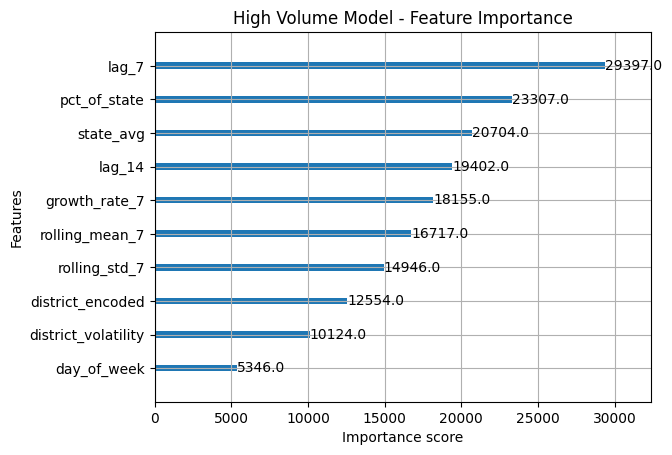

Analysis complete.


In [41]:
# Load Tuned Models and Analyze (Run After Tuning Cell)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

# Load saved tuned models
model_high = joblib.load('model_high_tuned.pkl')
model_low = joblib.load('model_low_tuned.pkl')

# Assuming test data from Cell 13 is available (X_test_high, X_test_low, y_test_high_orig, y_test_low_orig)
# If not, re-run Cell 13 up to the split part

# Predictions
y_test_pred_high_log = model_high.predict(X_test_high)
y_test_pred_high = np.exp(y_test_pred_high_log) - 1

y_test_pred_low_log = model_low.predict(X_test_low)
y_test_pred_low = np.exp(y_test_pred_low_log) - 1

# Combine predictions
y_test_pred_combined = pd.concat([
    pd.Series(y_test_pred_high, index=y_test_high_orig.index),
    pd.Series(y_test_pred_low, index=y_test_low_orig.index)
]).sort_index()

y_test_orig_combined = pd.concat([
    y_test_high_orig,
    y_test_low_orig
]).sort_index()

# Error by magnitude
errors_test = pd.DataFrame({
    'actual': y_test_orig_combined,
    'pred': y_test_pred_combined,
    'abs_error': np.abs(y_test_orig_combined - y_test_pred_combined)
})
errors_test['magnitude'] = pd.cut(errors_test['actual'], bins=[0, 100, 500, np.inf], labels=['small', 'medium', 'large'])
mag_errors = errors_test.groupby('magnitude', observed=False)['abs_error'].mean()
print(f"Error by magnitude (Tuned Model):\n{mag_errors}")

# Feature importance for high-volume model
xgb.plot_importance(model_high, max_num_features=10)
plt.title("High Volume Model - Feature Importance")
plt.show()

# Feature importance for low-volume model
xgb.plot_importance(model_low, max_num_features=10)
plt.title("Low Volume Model - Feature Importance")
plt.show()

print("Analysis complete.")

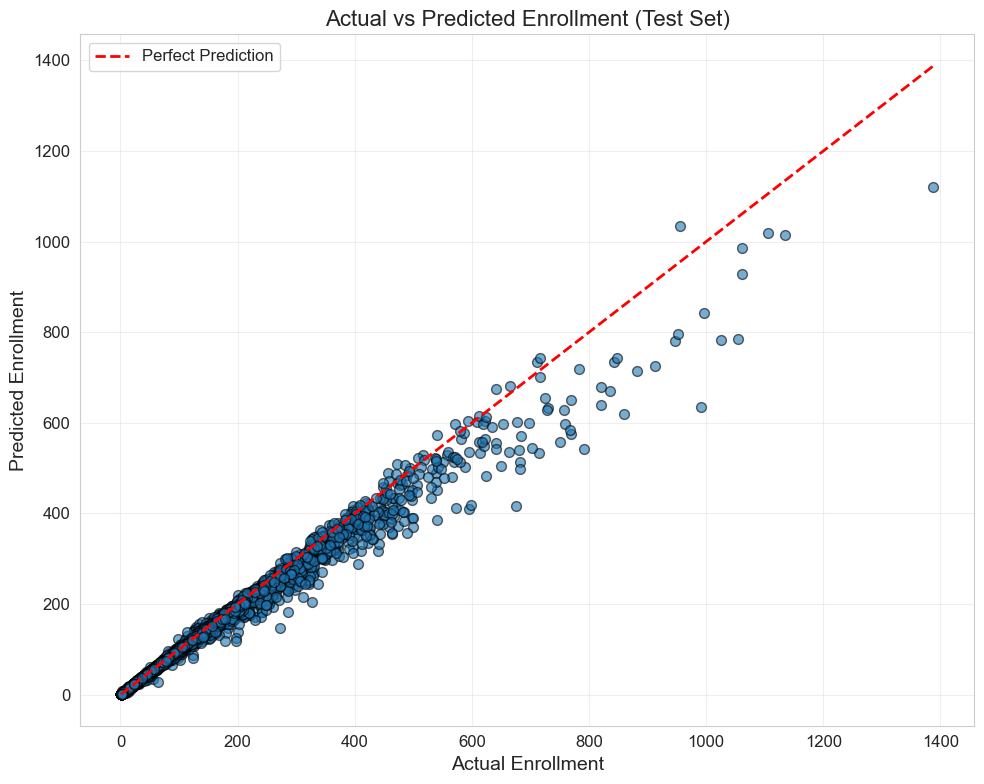

Selected districts for time series: ['South 24 Parganas', 'Pune']


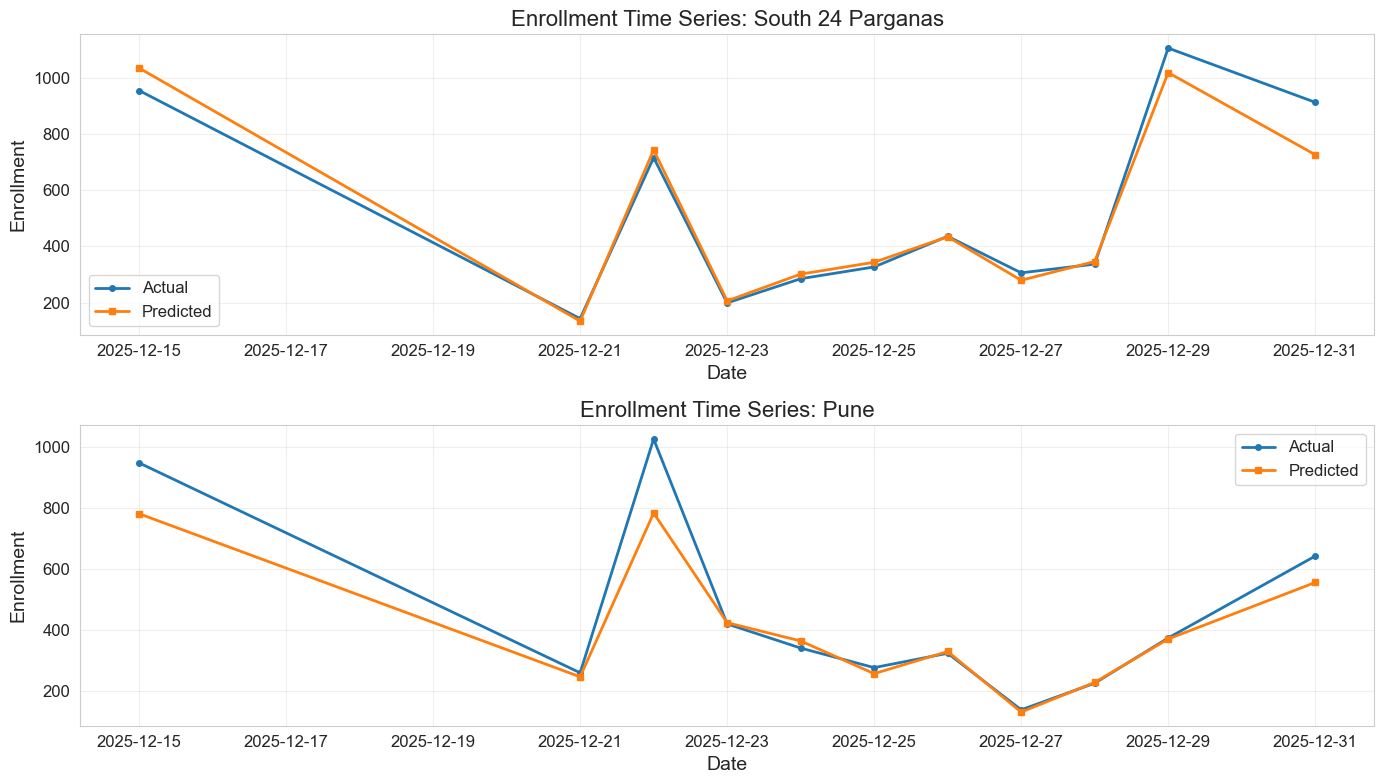

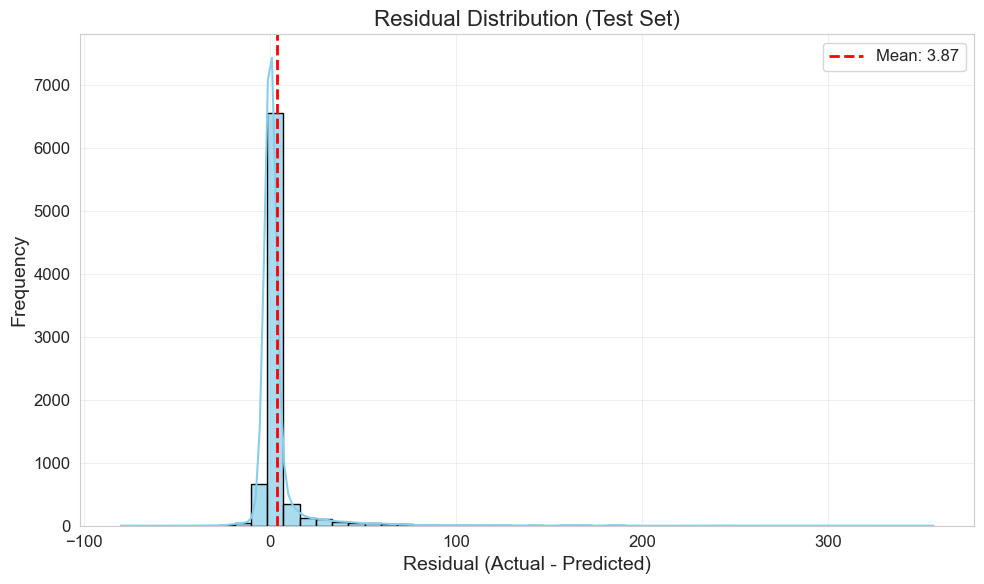

C:\Users\SINDHU\AppData\Local\Temp\ipykernel_16952\1272955208.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='magnitude', y='abs_error', data=errors_test, palette='Set2', showfliers=True)


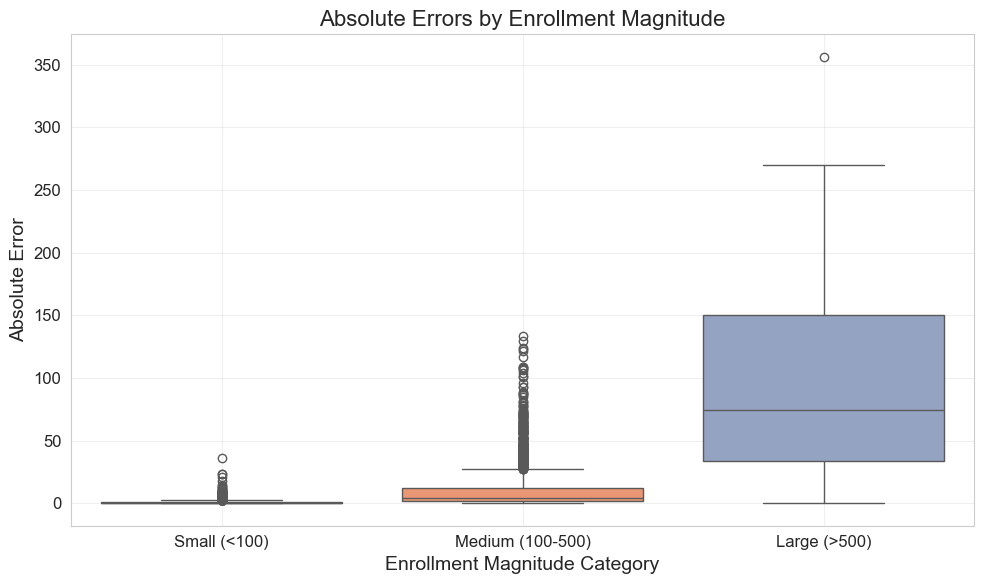

C:\Users\SINDHU\AppData\Local\Temp\ipykernel_16952\1272955208.py:88: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_rmse = daily_errors.groupby('date').apply(lambda x: np.sqrt(mean_squared_error(x['actual'], x['pred'])))


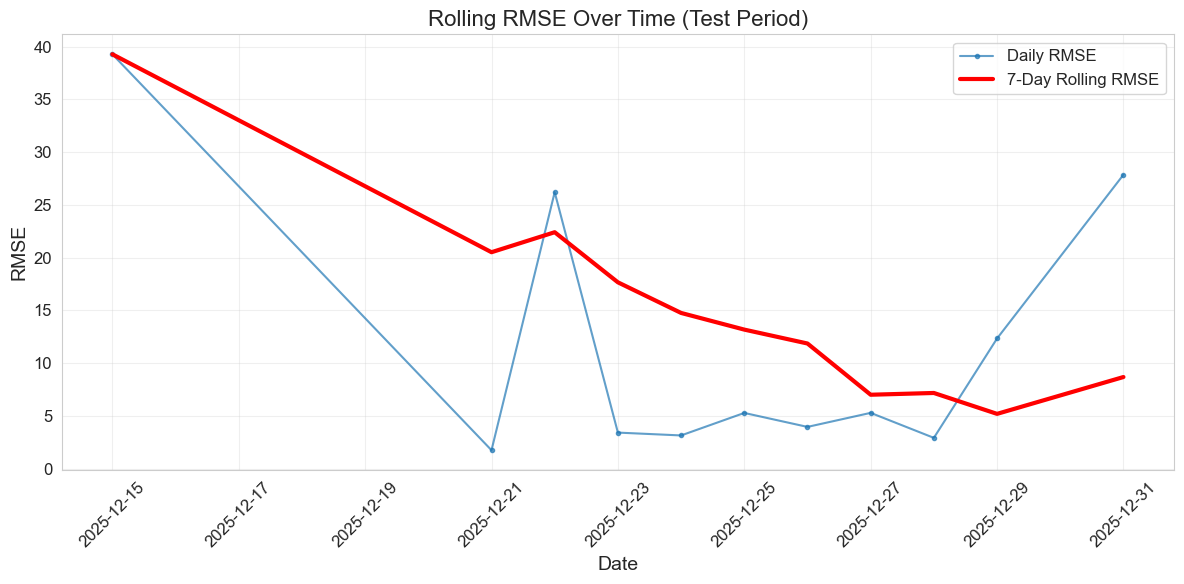

s:\UIDAI_Hackathon\hackenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


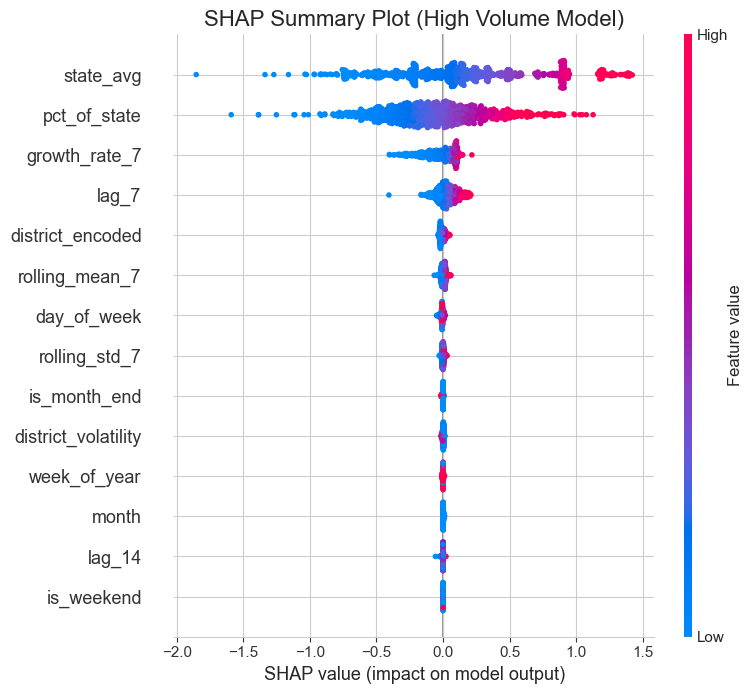

Visualization suite completed. All plots generated for model reliability assessment.


In [42]:
# Reliability Visualization Suite for Forecasting Model
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

# Set style for publication-quality plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 1. Actual vs Predicted Scatter Plot
plt.figure(figsize=(10, 8))
plt.scatter(y_test_orig_combined, y_test_pred_combined, alpha=0.6, edgecolors='k', s=50)
min_val = min(y_test_orig_combined.min(), y_test_pred_combined.min())
max_val = max(y_test_orig_combined.max(), y_test_pred_combined.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
plt.xlabel('Actual Enrollment')
plt.ylabel('Predicted Enrollment')
plt.title('Actual vs Predicted Enrollment (Test Set)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 2. Time Series Overlay for Two Selected Districts
# Select top 2 districts by mean enrollment in test set
top_districts = test_district_means.nlargest(2).index.tolist()
print(f"Selected districts for time series: {top_districts}")

plt.figure(figsize=(14, 8))
for i, district in enumerate(top_districts):
    district_data = df_agg[(df_agg['district'] == district) & test_mask].copy()
    district_orig_index = district_data.index  # Save original index for predictions
    district_data = district_data.set_index('date').sort_index()
    actual = district_data['total_enrollment']
    pred = y_test_pred_combined.loc[district_orig_index]
    pred = pd.Series(pred.values, index=actual.index)  # Align with actual dates

    plt.subplot(2, 1, i+1)
    plt.plot(actual.index, actual.values, label='Actual', linewidth=2, marker='o', markersize=4)
    plt.plot(pred.index, pred.values, label='Predicted', linewidth=2, marker='s', markersize=4)
    plt.title(f'Enrollment Time Series: {district}')
    plt.xlabel('Date')
    plt.ylabel('Enrollment')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3. Residual Distribution Histogram
residuals = y_test_orig_combined - y_test_pred_combined
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=50, kde=True, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(residuals.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {residuals.mean():.2f}')
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Residual Distribution (Test Set)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 4. Boxplot of Absolute Errors by Magnitude
plt.figure(figsize=(10, 6))
errors_test['magnitude'] = pd.cut(errors_test['actual'], bins=[0, 100, 500, np.inf], labels=['Small (<100)', 'Medium (100-500)', 'Large (>500)'])
sns.boxplot(x='magnitude', y='abs_error', data=errors_test, palette='Set2', showfliers=True)
plt.xlabel('Enrollment Magnitude Category')
plt.ylabel('Absolute Error')
plt.title('Absolute Errors by Enrollment Magnitude')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 5. Rolling RMSE Over Time (Sliding Window)
# Group by date and compute RMSE per date
daily_errors = pd.DataFrame({
    'date': df_agg.loc[test_mask, 'date'],
    'actual': y_test_orig_combined,
    'pred': y_test_pred_combined
})
daily_rmse = daily_errors.groupby('date').apply(lambda x: np.sqrt(mean_squared_error(x['actual'], x['pred'])))

# Rolling RMSE with window of 7 days
rolling_rmse = daily_rmse.rolling(window=7, min_periods=1).mean()

plt.figure(figsize=(12, 6))
plt.plot(daily_rmse.index, daily_rmse.values, label='Daily RMSE', alpha=0.7, marker='o', markersize=3)
plt.plot(rolling_rmse.index, rolling_rmse.values, label='7-Day Rolling RMSE', linewidth=3, color='red')
plt.xlabel('Date')
plt.ylabel('RMSE')
plt.title('Rolling RMSE Over Time (Test Period)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 6. Feature Importance (High Volume Model - already shown in previous cell)

# 7. SHAP Summary Plot (Optional)
import shap
explainer = shap.TreeExplainer(model_high)
shap_values = explainer.shap_values(X_test_high.sample(min(1000, len(X_test_high)), random_state=42))
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_high.sample(min(1000, len(X_test_high)), random_state=42), show=False)
plt.title('SHAP Summary Plot (High Volume Model)')
plt.tight_layout()
plt.show()

print("Visualization suite completed. All plots generated for model reliability assessment.")

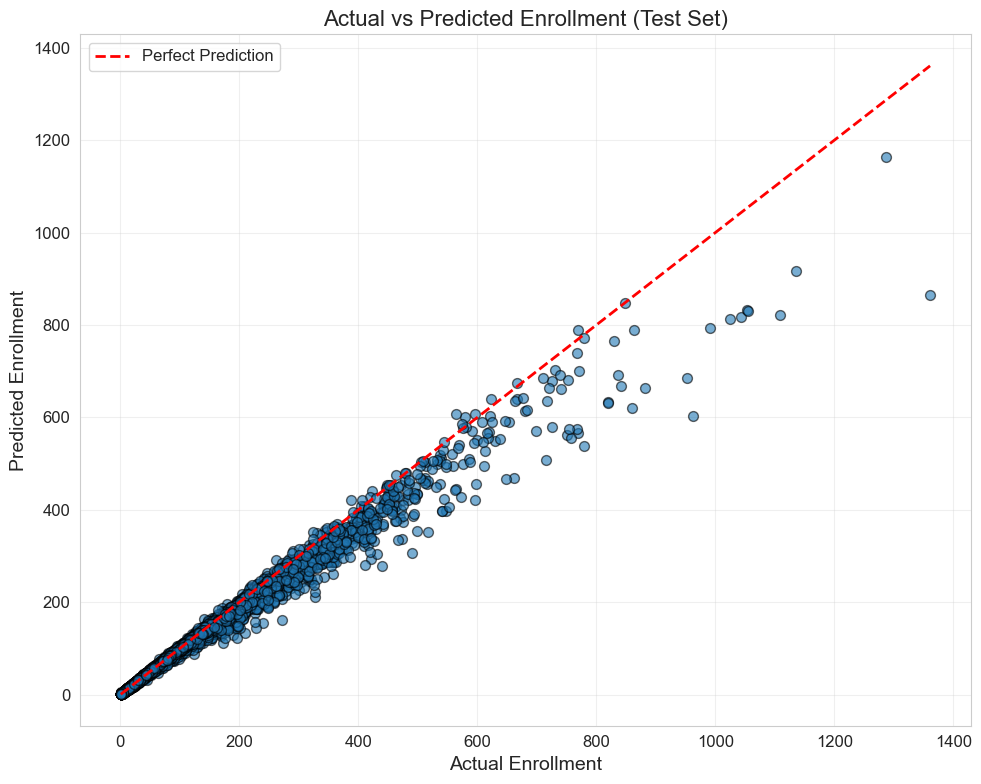

Selected districts for time series: ['Pune', 'South 24 Parganas']


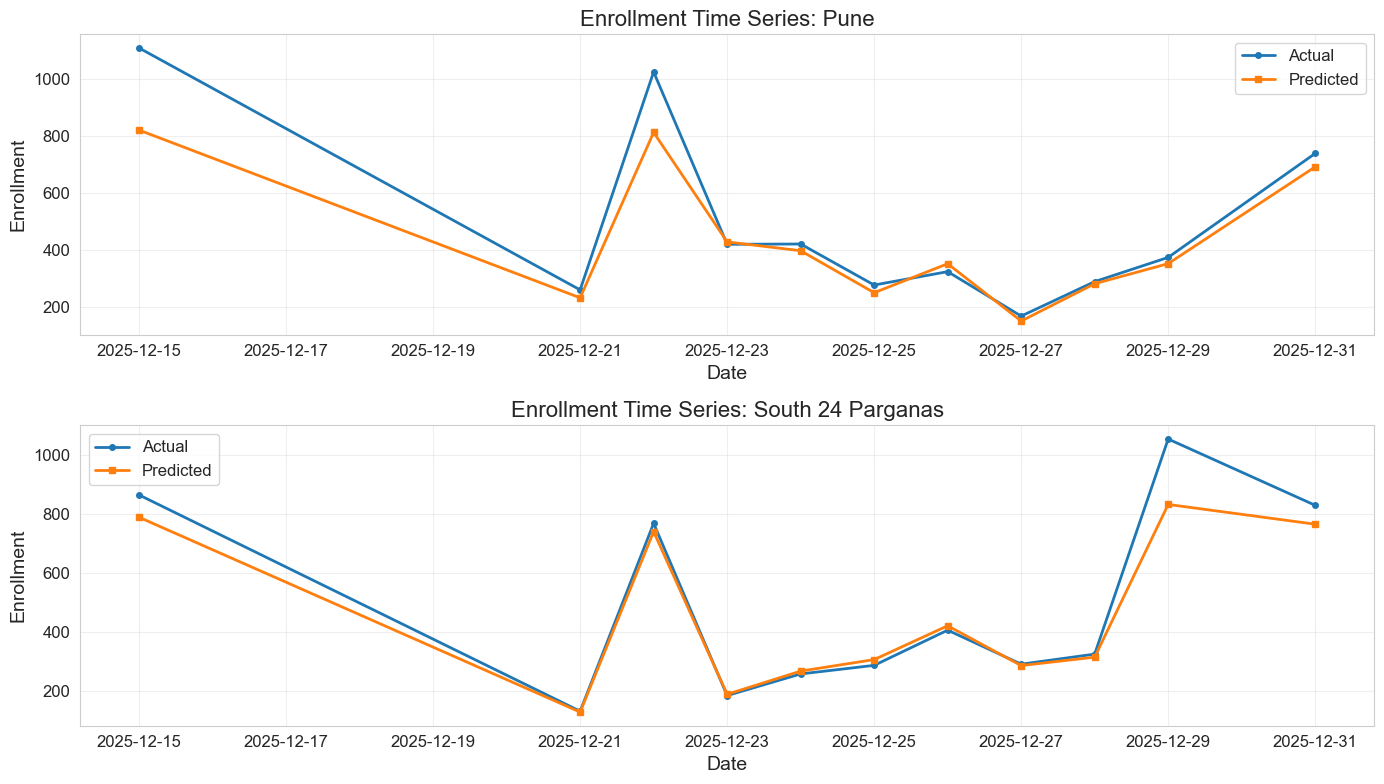

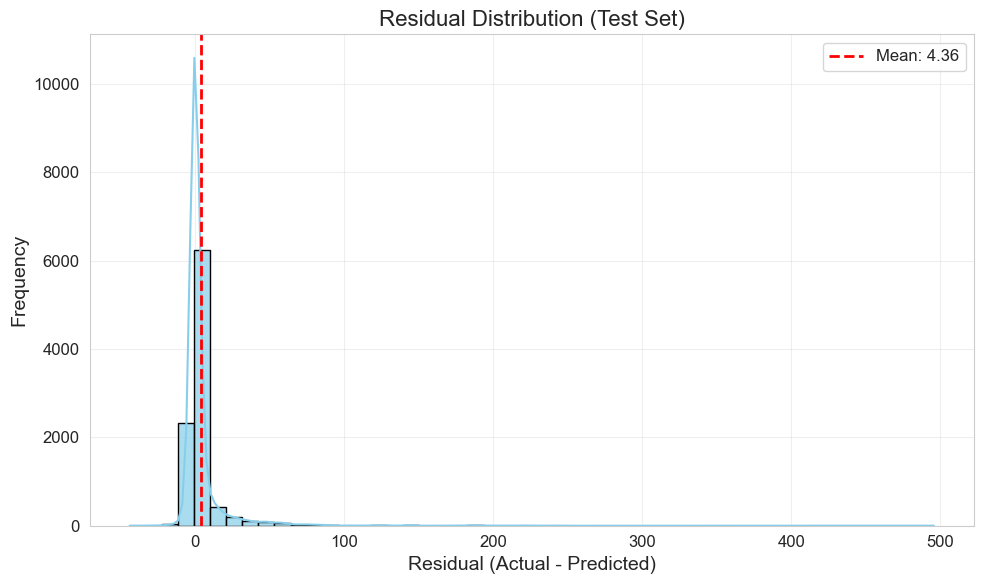

C:\Users\SINDHU\AppData\Local\Temp\ipykernel_11324\1272955208.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='magnitude', y='abs_error', data=errors_test, palette='Set2', showfliers=True)


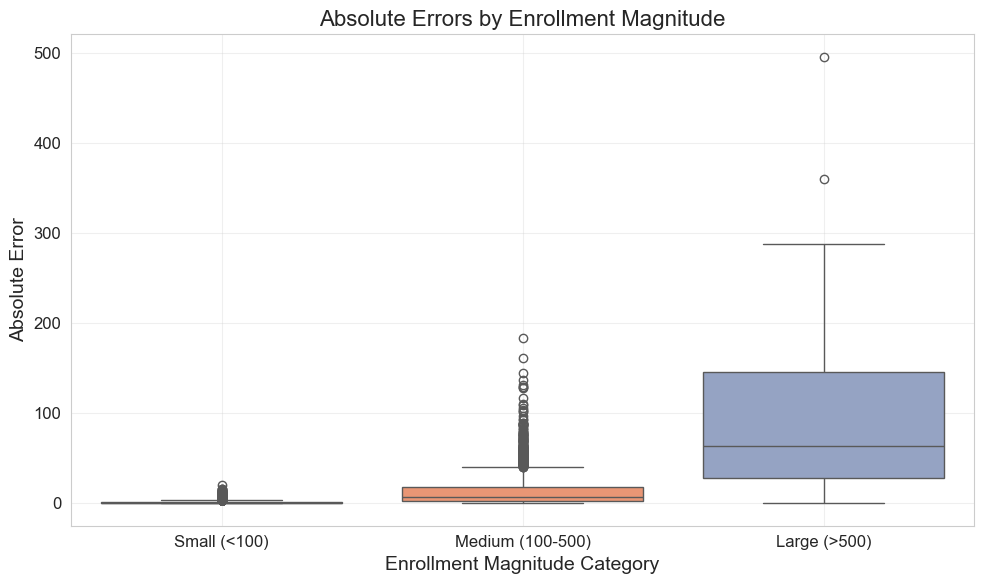

C:\Users\SINDHU\AppData\Local\Temp\ipykernel_11324\1272955208.py:88: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_rmse = daily_errors.groupby('date').apply(lambda x: np.sqrt(mean_squared_error(x['actual'], x['pred'])))


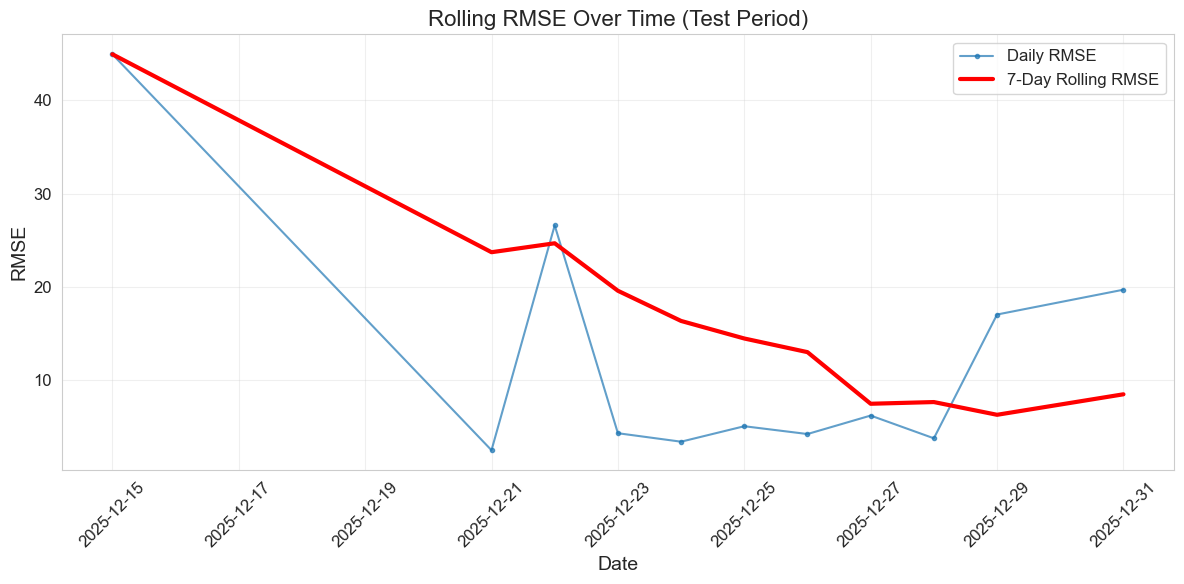

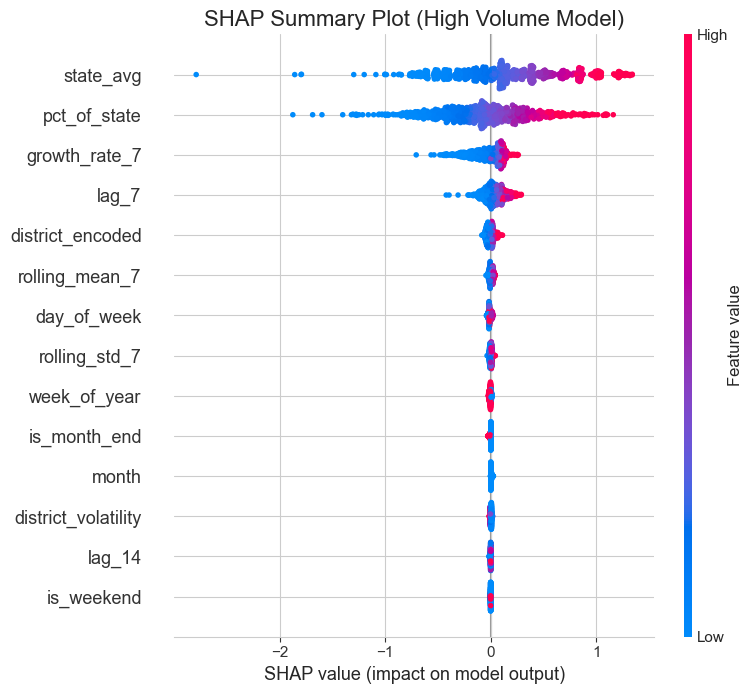

Visualization suite completed. All plots generated for model reliability assessment.


In [11]:
# Reliability Visualization Suite for Forecasting Model
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

# Set style for publication-quality plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 1. Actual vs Predicted Scatter Plot
plt.figure(figsize=(10, 8))
plt.scatter(y_test_orig_combined, y_test_pred_combined, alpha=0.6, edgecolors='k', s=50)
min_val = min(y_test_orig_combined.min(), y_test_pred_combined.min())
max_val = max(y_test_orig_combined.max(), y_test_pred_combined.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
plt.xlabel('Actual Enrollment')
plt.ylabel('Predicted Enrollment')
plt.title('Actual vs Predicted Enrollment (Test Set)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 2. Time Series Overlay for Two Selected Districts
# Select top 2 districts by mean enrollment in test set
top_districts = test_district_means.nlargest(2).index.tolist()
print(f"Selected districts for time series: {top_districts}")

plt.figure(figsize=(14, 8))
for i, district in enumerate(top_districts):
    district_data = df_agg[(df_agg['district'] == district) & test_mask].copy()
    district_orig_index = district_data.index  # Save original index for predictions
    district_data = district_data.set_index('date').sort_index()
    actual = district_data['total_enrollment']
    pred = y_test_pred_combined.loc[district_orig_index]
    pred = pd.Series(pred.values, index=actual.index)  # Align with actual dates

    plt.subplot(2, 1, i+1)
    plt.plot(actual.index, actual.values, label='Actual', linewidth=2, marker='o', markersize=4)
    plt.plot(pred.index, pred.values, label='Predicted', linewidth=2, marker='s', markersize=4)
    plt.title(f'Enrollment Time Series: {district}')
    plt.xlabel('Date')
    plt.ylabel('Enrollment')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3. Residual Distribution Histogram
residuals = y_test_orig_combined - y_test_pred_combined
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=50, kde=True, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(residuals.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {residuals.mean():.2f}')
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Residual Distribution (Test Set)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 4. Boxplot of Absolute Errors by Magnitude
plt.figure(figsize=(10, 6))
errors_test['magnitude'] = pd.cut(errors_test['actual'], bins=[0, 100, 500, np.inf], labels=['Small (<100)', 'Medium (100-500)', 'Large (>500)'])
sns.boxplot(x='magnitude', y='abs_error', data=errors_test, palette='Set2', showfliers=True)
plt.xlabel('Enrollment Magnitude Category')
plt.ylabel('Absolute Error')
plt.title('Absolute Errors by Enrollment Magnitude')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 5. Rolling RMSE Over Time (Sliding Window)
# Group by date and compute RMSE per date
daily_errors = pd.DataFrame({
    'date': df_agg.loc[test_mask, 'date'],
    'actual': y_test_orig_combined,
    'pred': y_test_pred_combined
})
daily_rmse = daily_errors.groupby('date').apply(lambda x: np.sqrt(mean_squared_error(x['actual'], x['pred'])))

# Rolling RMSE with window of 7 days
rolling_rmse = daily_rmse.rolling(window=7, min_periods=1).mean()

plt.figure(figsize=(12, 6))
plt.plot(daily_rmse.index, daily_rmse.values, label='Daily RMSE', alpha=0.7, marker='o', markersize=3)
plt.plot(rolling_rmse.index, rolling_rmse.values, label='7-Day Rolling RMSE', linewidth=3, color='red')
plt.xlabel('Date')
plt.ylabel('RMSE')
plt.title('Rolling RMSE Over Time (Test Period)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 6. Feature Importance (High Volume Model - already shown in previous cell)

# 7. SHAP Summary Plot (Optional)
import shap
explainer = shap.TreeExplainer(model_high)
shap_values = explainer.shap_values(X_test_high.sample(min(1000, len(X_test_high)), random_state=42))
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_high.sample(min(1000, len(X_test_high)), random_state=42), show=False)
plt.title('SHAP Summary Plot (High Volume Model)')
plt.tight_layout()
plt.show()

print("Visualization suite completed. All plots generated for model reliability assessment.")

In [1]:
print("Hello")

Hello


<Figure size 1200x600 with 0 Axes>

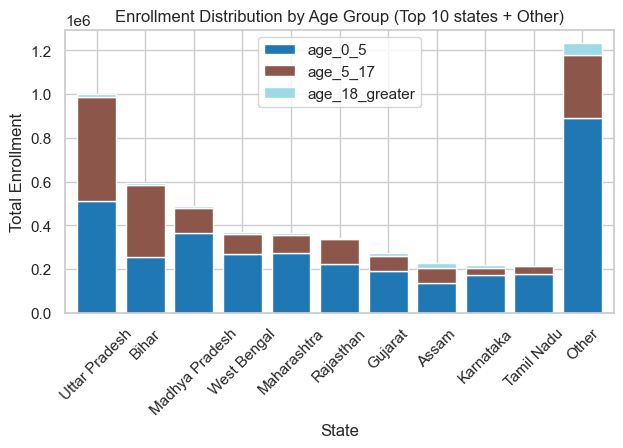

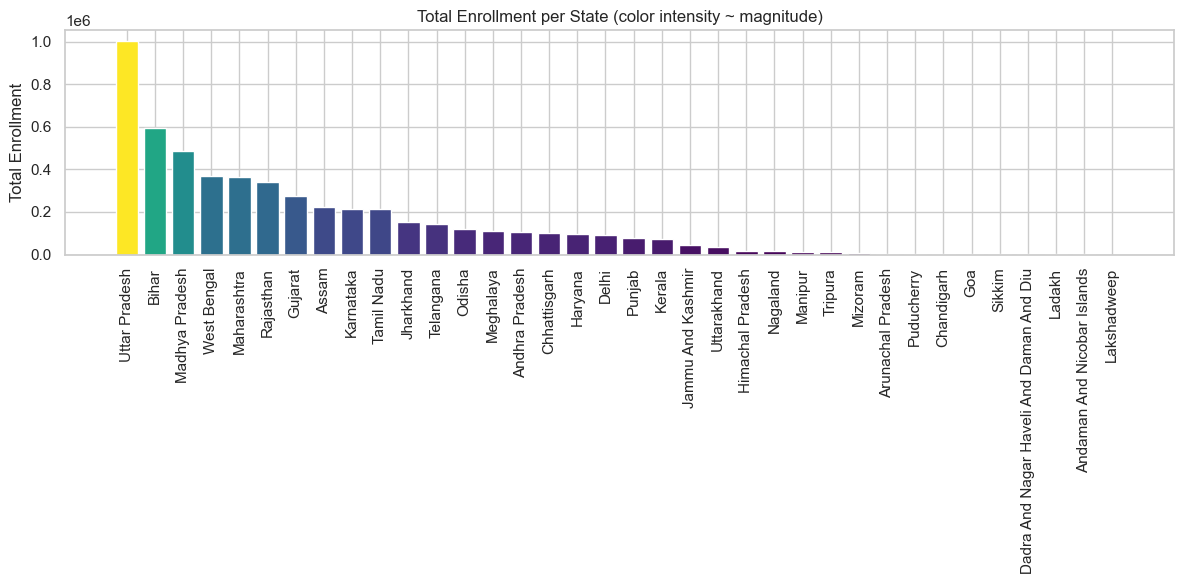

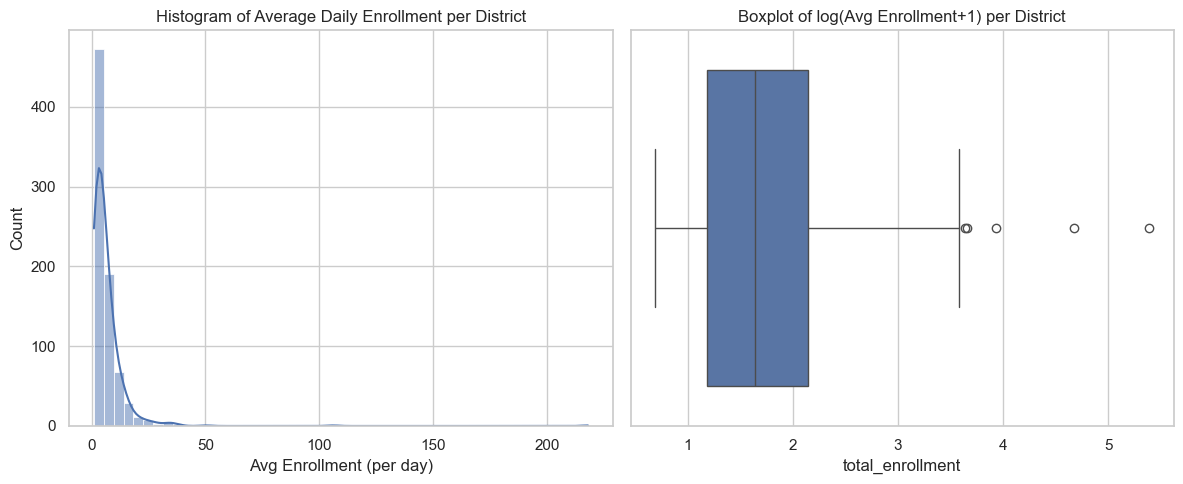

<Figure size 1400x600 with 0 Axes>

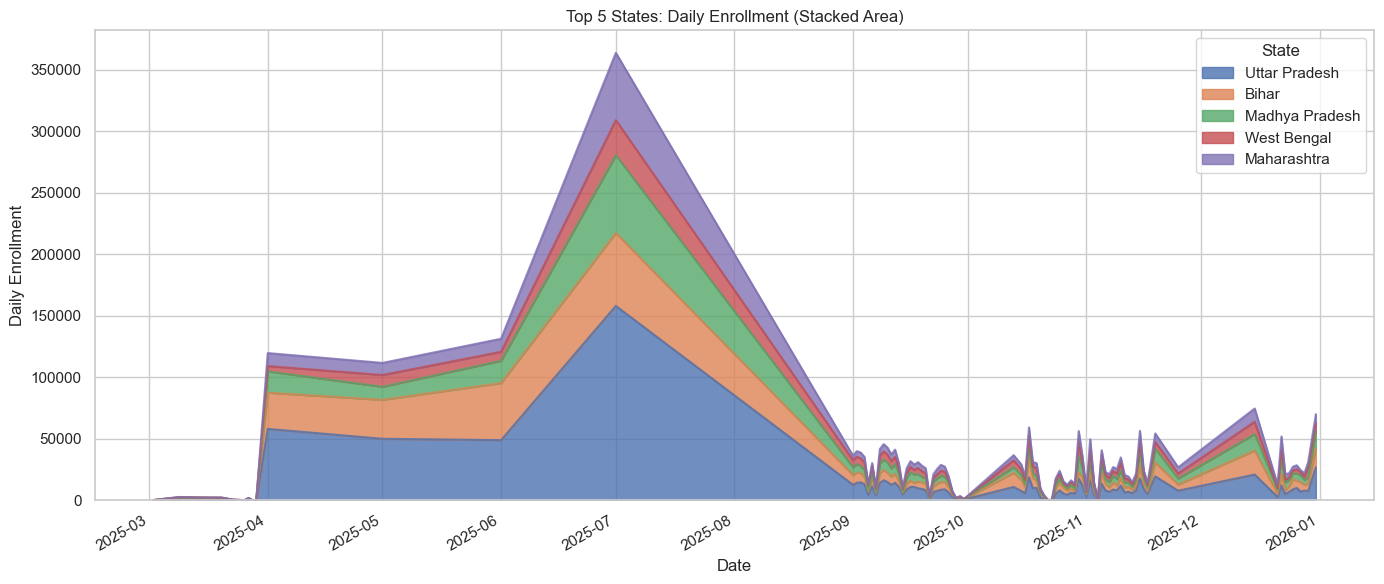


Bonus insights:
Relative mean by weekday (0=Mon): {0: 0.78, 1: 1.84, 2: 0.85, 3: 1.02, 4: 0.74, 5: 0.73, 6: 1.05}

Top 5 states by total enrollment:
state
Uttar Pradesh     1002530
Bihar              593734
Madhya Pradesh     487682
West Bengal        367596
Maharashtra        362796
Name: total_enrollment, dtype: int64

Top states age-group split (as %)
                age_0_5  age_5_17  age_18_greater
state                                            
Uttar Pradesh      0.51      0.47            0.02
Bihar              0.43      0.55            0.02
Madhya Pradesh     0.74      0.24            0.02
West Bengal        0.73      0.25            0.02
Maharashtra        0.75      0.22            0.02

Top 10 districts by coefficient of variation:
       district       mean         std         cv
39   Aurangabad   7.870124   84.515755  10.738809
229   Firozabad  10.857658  107.810254   9.929421
22     Amritsar   6.233834   58.151370   9.328347
566   Prayagraj   2.810277   23.828757   8.47

In [3]:
# --- Additional Exploratory Visualizations (state/district-level, original data) ---
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
sns.set(style='whitegrid')

# Load original merged data and ensure datetime
df_orig = pd.read_csv(r'S:\UIDAI_Hackathon\api_data_aadhar_enrolment\merged_final.csv')
df_orig['date'] = pd.to_datetime(df_orig['date'], format='%d-%m-%Y')

# Compute total enrollment
df_orig['total_enrollment'] = df_orig['age_0_5'] + df_orig['age_5_17'] + df_orig['age_18_greater']

# 1) Enrollment Distribution by Age Group (Stacked Bar) for top states
state_age = df_orig.groupby('state')[['age_0_5','age_5_17','age_18_greater']].sum()
state_age['total'] = state_age.sum(axis=1)
# Top 10 states and aggregate rest as 'Other'
top_states = state_age.sort_values('total', ascending=False).head(10)
others = state_age.sort_values('total', ascending=False).iloc[10:].sum()
others.name = 'Other'
plot_df = pd.concat([top_states, pd.DataFrame([others])])

plt.figure(figsize=(12,6))
plot_df[['age_0_5','age_5_17','age_18_greater']].plot(kind='bar', stacked=True, colormap='tab20', width=0.8)
plt.title('Enrollment Distribution by Age Group (Top 10 states + Other)')
plt.ylabel('Total Enrollment')
plt.xlabel('State')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2) Time Series: Daily Enrollment Trend (Mar-Dec 2025) with 7-day MA
# Ensure the datetime index is sorted before partial slicing to avoid KeyError on non-monotonic index
ts = (
    df_orig.set_index('date').sort_index()
    .loc['2025-03-01':'2025-12-31']['total_enrollment']
    .resample('D').sum().fillna(0)
)
ma7 = ts.rolling(7).mean()
plt.figure(figsize=(14,5))
plt.plot(ts.index, ts.values, label='Daily Total Enrollment', alpha=0.6)
plt.plot(ma7.index, ma7.values, label='7-day MA', color='red')
plt.title('Daily Enrollment Trend (Mar-Dec 2025) with 7-day MA')
plt.ylabel('Total Enrollment')
plt.xlabel('Date')
plt.legend()
plt.tight_layout()
plt.show()

# 3) State 'choropleth-like' bar (color intensity by total)
state_tot = df_orig.groupby('state')['total_enrollment'].sum().sort_values(ascending=False)
plt.figure(figsize=(12,6))
colors = plt.cm.viridis((state_tot - state_tot.min())/(state_tot.max()-state_tot.min()))
plt.bar(state_tot.index, state_tot.values, color=colors)
plt.xticks(rotation=90)
plt.title('Total Enrollment per State (color intensity ~ magnitude)')
plt.ylabel('Total Enrollment')
plt.tight_layout()
plt.show()

# 4) District Size Distribution (Histogram + Box Plot)
district_avg = df_orig.groupby('district')['total_enrollment'].mean()
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(district_avg, bins=50, kde=True)
plt.title('Histogram of Average Daily Enrollment per District')
plt.xlabel('Avg Enrollment (per day)')
plt.subplot(1,2,2)
sns.boxplot(x=np.log1p(district_avg))
plt.title('Boxplot of log(Avg Enrollment+1) per District')
plt.tight_layout()
plt.show()

# 5) Volatility vs Enrollment Size (Scatter)
df_vol = df_orig.groupby('district').agg(avg_enroll=('total_enrollment','mean'), vol=('total_enrollment','std')).dropna()
plt.figure(figsize=(10,6))
plt.scatter(df_vol['avg_enroll'], df_vol['vol'], alpha=0.6)
plt.xscale('log')
plt.xlabel('Average Enrollment (log scale)')
plt.ylabel('Volatility (std)')
plt.title('Volatility vs District Size')
plt.tight_layout()
plt.show()

# 6) Day of Week Patterns (Box Plot)
dow = df_orig.copy()
dow['day_name'] = dow['date'].dt.day_name()
plt.figure(figsize=(10,5))
sns.boxplot(x='day_name', y='total_enrollment', data=dow, order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.ylim(0, dow['total_enrollment'].quantile(0.95))
plt.title('Enrollment by Day of Week (boxplot, 95th pct cap)')
plt.tight_layout()
plt.show()

# 7) State Contribution Over Time (Stacked Area for Top 5 states)
state_daily = df_orig.set_index('date').groupby([pd.Grouper(freq='D'),'state'])['total_enrollment'].sum().unstack(fill_value=0)
top5 = state_tot.head(5).index.tolist()
state_daily_top5 = state_daily[top5]
plt.figure(figsize=(14,6))
state_daily_top5.plot.area(figsize=(14,6), alpha=0.8)
plt.title('Top 5 States: Daily Enrollment (Stacked Area)')
plt.ylabel('Daily Enrollment')
plt.xlabel('Date')
plt.legend(title='State')
plt.tight_layout()
plt.show()

# Bonus insights: weekend effect, age distribution, outlier districts
print('\nBonus insights:')
weekday_means = dow.groupby(dow['date'].dt.dayofweek)['total_enrollment'].mean()
weekday_mean_norm = (weekday_means / weekday_means.mean()).round(2)
print('Relative mean by weekday (0=Mon):', weekday_mean_norm.to_dict())

print('\nTop 5 states by total enrollment:')
print(state_tot.head(5))

print('\nTop states age-group split (as %)')
top5_age = df_orig.groupby('state')[['age_0_5','age_5_17','age_18_greater']].sum().loc[top5]
age_pct = (top5_age.T / top5_age.sum(axis=1)).T
print(age_pct.round(2))

# Outlier districts (by CV)
df_d = df_orig.groupby('district')['total_enrollment'].agg(['mean','std']).reset_index()
df_d['cv'] = df_d['std'] / (df_d['mean'] + 1e-9)
print('\nTop 10 districts by coefficient of variation:')
print(df_d.sort_values('cv', ascending=False).head(10)[['district','mean','std','cv']])

print('\nExploratory plots generated (state/district-level).')

In [8]:
# Export exploratory visuals + bonus insights to a compact multi-page PDF
import os
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

sns.set(style='whitegrid')

out_dir = r'S:\UIDAI_Hackathon\reports'
os.makedirs(out_dir, exist_ok=True)
pdf_path = os.path.join(out_dir, 'exploratory_report.pdf')

# Reload original data to ensure independence
df_orig = pd.read_csv(r'S:\UIDAI_Hackathon\api_data_aadhar_enrolment\merged_final.csv')
df_orig['date'] = pd.to_datetime(df_orig['date'], format='%d-%m-%Y')
df_orig['total_enrollment'] = df_orig['age_0_5'] + df_orig['age_5_17'] + df_orig['age_18_greater']

# Compute metrics used in plots
state_age = df_orig.groupby('state')[['age_0_5','age_5_17','age_18_greater']].sum()
state_age['total'] = state_age.sum(axis=1)
top_states = state_age.sort_values('total', ascending=False).head(8)
state_tot = df_orig.groupby('state')['total_enrollment'].sum().sort_values(ascending=False)

# Time series for Mar-Dec 2025
ts = (
    df_orig.set_index('date').sort_index()
    .loc['2025-03-01':'2025-12-31']['total_enrollment']
    .resample('D').sum().fillna(0)
)
ma7 = ts.rolling(7).mean()

# District & volatility
district_avg = df_orig.groupby('district')['total_enrollment'].mean()
df_vol = df_orig.groupby('district').agg(avg_enroll=('total_enrollment','mean'), vol=('total_enrollment','std')).dropna()

# Day-of-week
dow = df_orig.copy()
dow['day_name'] = dow['date'].dt.day_name()

# Top 5 states time series
state_daily = df_orig.set_index('date').groupby([pd.Grouper(freq='D'),'state'])['total_enrollment'].sum().unstack(fill_value=0)
top5 = state_tot.head(5).index.tolist()
state_daily_top5 = state_daily[top5]

# Bonus insights
weekday_means = dow.groupby(dow['date'].dt.dayofweek)['total_enrollment'].mean()
weekday_mean_norm = (weekday_means / weekday_means.mean()).round(2)

age_pct = (df_orig.groupby('state')[['age_0_5','age_5_17','age_18_greater']].sum().loc[top5])
age_pct = (age_pct.T / age_pct.sum(axis=1)).T.round(2)

# Top CV districts
df_d = df_orig.groupby('district')['total_enrollment'].agg(['mean','std']).reset_index()
df_d['cv'] = df_d['std'] / (df_d['mean'] + 1e-9)
top_cv = df_d.sort_values('cv', ascending=False).head(10)[['district','mean','std','cv']]

# Print summaries to console
print('Saving exploratory report to:', pdf_path)
print('\nBonus insights:')
print('Relative mean by weekday (0=Mon):', weekday_mean_norm.to_dict())
print('\nTop 5 states by total enrollment:')
print(state_tot.head(5))
print('\nTop states age-group split (as %) for top5:')
print(age_pct)
print('\nTop 10 districts by coefficient of variation:')
print(top_cv)

# Create PDF with compact pages
with PdfPages(pdf_path) as pp:
    # Page 1: Age stacked (Top 8 states)
    fig = plt.figure(figsize=(11,4))
    ax = fig.add_subplot(111)
    top_states[['age_0_5','age_5_17','age_18_greater']].plot(kind='bar', stacked=True, colormap='tab20', ax=ax)
    ax.set_title('Age Group Distribution (Top 8 states)')
    ax.set_ylabel('Total Enrollment')
    plt.xticks(rotation=45)
    plt.tight_layout()
    pp.savefig(fig, bbox_inches='tight')
    plt.close(fig)

    # Page 2: Total Enrollment per State
    fig = plt.figure(figsize=(11,4))
    colors = plt.cm.viridis((state_tot - state_tot.min())/(state_tot.max()-state_tot.min()))
    plt.bar(state_tot.index, state_tot.values, color=colors)
    plt.title('Total Enrollment per State')
    plt.xticks(fontsize=3,rotation=90)
    plt.tight_layout()
    pp.savefig(fig, bbox_inches='tight')
    plt.close(fig)

    # Page 3: Daily trend with 7-day MA (full width but compact)
    fig = plt.figure(figsize=(11,4))
    plt.plot(ts.index, ts.values, label='Daily Total Enrollment', alpha=0.6)
    plt.plot(ma7.index, ma7.values, label='7-day MA', color='red')
    plt.title('Daily Enrollment Trend (Mar-Dec 2025)')
    plt.ylabel('Total Enrollment')
    plt.xlabel('Date')
    plt.legend()
    plt.tight_layout()
    pp.savefig(fig, bbox_inches='tight')
    plt.close(fig)

    # Page 4: Stacked area for top5 (compact)
    fig = plt.figure(figsize=(11,4))
    state_daily_top5.plot.area(ax=plt.gca(), alpha=0.8)
    plt.title('Top 5 States: Daily Enrollment (Stacked Area)')
    plt.ylabel('Daily Enrollment')
    plt.xlabel('Date')
    plt.legend(title='State', fontsize=8)
    plt.tight_layout()
    pp.savefig(fig, bbox_inches='tight')
    plt.close(fig)

    # Page 5: District histogram + boxplot
    fig, axes = plt.subplots(1,2, figsize=(11,4))
    sns.histplot(district_avg, bins=50, kde=True, ax=axes[0])
    axes[0].set_title('Histogram of Avg Daily Enrollment per District')
    axes[0].set_xlabel('Avg Enrollment (per day)')
    sns.boxplot(x=np.log1p(district_avg), ax=axes[1])
    axes[1].set_title('Boxplot of log(Avg Enrollment+1)')
    plt.tight_layout()
    pp.savefig(fig, bbox_inches='tight')
    plt.close(fig)

    # Page 6: Volatility vs size + DOW boxplot
    fig, axes = plt.subplots(1,2, figsize=(11,4))
    axes[0].scatter(df_vol['avg_enroll'], df_vol['vol'], alpha=0.6)
    axes[0].set_xscale('log')
    axes[0].set_xlabel('Average Enrollment (log scale)')
    axes[0].set_ylabel('Volatility (std)')
    axes[0].set_title('Volatility vs District Size')

    sns.boxplot(x='day_name', y='total_enrollment', data=dow, order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], ax=axes[1])
    axes[1].set_ylim(0, dow['total_enrollment'].quantile(0.95))
    axes[1].set_title('Enrollment by Day of Week (95th pct cap)')
    plt.tight_layout()
    pp.savefig(fig, bbox_inches='tight')
    plt.close(fig)

    # Page 7: Text summary (bonus insights and top CV table)
    fig = plt.figure(figsize=(8.5, 11))
    plt.axis('off')
    lines = []
    lines.append('Bonus insights:')
    lines.append('Relative mean by weekday (0=Mon): ' + str(weekday_mean_norm.to_dict()))
    lines.append('\nTop 5 states by total enrollment:')
    lines.extend([f'  {s}: {int(state_tot[s])}' for s in state_tot.head(5).index])
    lines.append('\nTop states age-group split (top5):')
    for st in top5:
        lines.append(f"  {st}: age_0_5={age_pct.loc[st,'age_0_5']}, age_5_17={age_pct.loc[st,'age_5_17']}, age_18_greater={age_pct.loc[st,'age_18_greater']}")
    lines.append('\nTop 10 districts by coefficient of variation:')
    for i, row in top_cv.iterrows():
        lines.append(f"  {row['district']}: mean={row['mean']:.2f}, std={row['std']:.2f}, cv={row['cv']:.2f}")

    txt = '\n'.join(lines)
    plt.text(0.01, 0.99, txt, va='top', fontsize=9, family='monospace')
    pp.savefig(fig, bbox_inches='tight')
    plt.close(fig)

print('Saved PDF:', pdf_path)

Saving exploratory report to: S:\UIDAI_Hackathon\reports\exploratory_report.pdf

Bonus insights:
Relative mean by weekday (0=Mon): {0: 0.78, 1: 1.84, 2: 0.85, 3: 1.02, 4: 0.74, 5: 0.73, 6: 1.05}

Top 5 states by total enrollment:
state
Uttar Pradesh     1002530
Bihar              593734
Madhya Pradesh     487682
West Bengal        367596
Maharashtra        362796
Name: total_enrollment, dtype: int64

Top states age-group split (as %) for top5:
                age_0_5  age_5_17  age_18_greater
state                                            
Uttar Pradesh      0.51      0.47            0.02
Bihar              0.43      0.55            0.02
Madhya Pradesh     0.74      0.24            0.02
West Bengal        0.73      0.25            0.02
Maharashtra        0.75      0.22            0.02

Top 10 districts by coefficient of variation:
       district       mean         std         cv
39   Aurangabad   7.870124   84.515755  10.738809
229   Firozabad  10.857658  107.810254   9.929421
22   

In [15]:
# Check for Duplicates in Dataset
import pandas as pd

# Load the merged dataset
df = pd.read_csv(r'S:\UIDAI_Hackathon\api_data_aadhar_enrolment\api_data_aadhar_enrolment_merged.csv')

print('Total rows:', len(df))

# Check for duplicates based on date, state, district, pincode
duplicates = df.duplicated(subset=['date', 'state', 'district', 'pincode'], keep=False)
print('Number of duplicate rows (including originals):', duplicates.sum())

if duplicates.sum() > 0:
    print('\nDuplicate groups (count of identical rows per group):')
    duplicate_groups = df[duplicates].groupby(['date', 'state', 'district', 'pincode']).size()
    print(duplicate_groups.head(10))

    print('\nSample of actual duplicate pairs (showing first 2 examples):')
    # Get groups with more than 1 duplicate
    dup_groups = duplicate_groups[duplicate_groups > 1]
    for i, ((date, state, district, pincode), count) in enumerate(dup_groups.head(2).items()):
        print(f"\nDuplicate group {i+1}: {date}, {state}, {district}, {pincode} (appears {count} times)")
        mask = (df['date'] == date) & (df['state'] == state) & (df['district'] == district) & (df['pincode'] == pincode)
        print(df[mask].head(count))  # Show all instances
else:
    print('No duplicates found based on date, state, district, pincode.')

Total rows: 1006029
Number of duplicate rows (including originals): 47437

Duplicate groups (count of identical rows per group):
date        state      district             pincode
2025-09-01  Jharkhand  Seraikela-Kharsawan  832108     2
                                            832109     2
                                            832401     2
                                            832402     2
                                            832403     2
                                            832404     2
                                            833216     2
                                            833219     2
            Karnataka  Yadgir               585202     2
                                            585214     2
dtype: int64

Sample of actual duplicate pairs (showing first 2 examples):

Duplicate group 1: 2025-09-01, Jharkhand, Seraikela-Kharsawan, 832108 (appears 2 times)
             date      state             district  pincode  age_0_5  age_5_17  \
1639

In [9]:
# Check for Exact Duplicates (Whole Row Match)
import pandas as pd

# Load the merged dataset
df = pd.read_csv(r'S:\UIDAI_Hackathon\api_data_aadhar_enrolment\merged_final.csv')
df = df.drop_duplicates()

print('Total rows:', len(df))

# Check for exact duplicates (all columns identical)
exact_duplicates = df.duplicated(keep=False)
print('Number of exact duplicate rows (including originals):', exact_duplicates.sum())

if exact_duplicates.sum() > 0:
    print('\nExact duplicate groups (count per group):')
    # Group by all columns to count exact duplicates
    exact_dup_groups = df[exact_duplicates].groupby(list(df.columns)).size()
    print(f"Number of unique exact duplicate groups: {len(exact_dup_groups)}")
    print(f"Total exact duplicates: {exact_dup_groups.sum()}")

    print('\nSample of exact duplicate pairs (showing first 3 examples):')
    for i, ((group_data), count) in enumerate(exact_dup_groups.head(3).items()):
        print(f"\nExact duplicate group {i+1} (appears {count} times):")
        # Find the rows that match this group
        mask = (df == group_data).all(axis=1)
        print(df[mask].head(count))
else:
    print('No exact duplicates found (no rows are completely identical).')

Total rows: 973807
Number of exact duplicate rows (including originals): 0
No exact duplicates found (no rows are completely identical).


In [11]:
# Find Districts with Same Pincode
import pandas as pd

# Load the merged dataset
df = pd.read_csv(r'S:\UIDAI_Hackathon\api_data_aadhar_enrolment\merged_final.csv')

print('Total rows:', len(df))

# Group by pincode and find unique districts for each pincode
pincode_districts = df.groupby('pincode')['district'].unique()

# Filter for pincodes that have multiple districts
shared_pincodes = pincode_districts[pincode_districts.apply(len) > 1]

print(f"\nNumber of pincodes shared across multiple districts: {len(shared_pincodes)}")

if len(shared_pincodes) > 0:
    print("\nShared pincodes and their districts:")
    for pincode, districts in shared_pincodes.items():
        print(f"Pincode {pincode}: {list(districts)}")

    print(f"\nTotal unique districts involved: {len(set(district for districts in shared_pincodes for district in districts))}")

    # Show some statistics
    district_counts = shared_pincodes.apply(len)
    print(f"\nDistribution of shared pincodes:")
    print(f"Most shared: {district_counts.max()} districts per pincode")
    print(f"Average: {district_counts.mean():.1f} districts per pincode")

    # Show sample of the most shared pincodes
    most_shared = shared_pincodes[district_counts == district_counts.max()]
    if len(most_shared) > 0:
        print(f"\nExample of most shared pincode:")
        pincode = most_shared.index[0]
        districts = most_shared.iloc[0]
        print(f"Pincode {pincode} is used by {len(districts)} districts: {list(districts)}")
else:
    print("No pincodes are shared across multiple districts.")

Total rows: 973839

Number of pincodes shared across multiple districts: 4125

Shared pincodes and their districts:
Pincode 110001: ['Central Delhi', 'New Delhi']
Pincode 110003: ['Central Delhi', 'New Delhi', 'South Delhi']
Pincode 110007: ['Central Delhi', 'North Delhi']
Pincode 110011: ['Central Delhi', 'New Delhi']
Pincode 110016: ['South Delhi', 'South West Delhi']
Pincode 110021: ['New Delhi', 'South West Delhi']
Pincode 110023: ['New Delhi', 'South West Delhi']
Pincode 110025: ['South Delhi', 'South East Delhi']
Pincode 110029: ['South Delhi', 'South West Delhi']
Pincode 110030: ['South Delhi', 'South West Delhi']
Pincode 110032: ['Shahdara', 'East Delhi', 'North East Delhi']
Pincode 110037: ['South West Delhi', 'New Delhi']
Pincode 110039: ['North Delhi', 'North West Delhi']
Pincode 110040: ['North West Delhi', 'North Delhi']
Pincode 110043: ['South West Delhi', 'West Delhi', 'Najafgarh']
Pincode 110047: ['South Delhi', 'South West Delhi']
Pincode 110053: ['North East Delhi', '

In [19]:
# List All States and Their Districts
import pandas as pd

# Load the merged dataset
df = pd.read_csv(r'S:\UIDAI_Hackathon\api_data_aadhar_enrolment\merged_final.csv')

print('Total rows:', len(df))

# Group by state and get unique districts
state_districts = df.groupby('state')['district'].unique().reset_index()

# Create a comprehensive list of all state-district pairs
all_pairs = []
for _, row in state_districts.iterrows():
    state = row['state']
    districts = row['district']
    for district in districts:
        all_pairs.append({'state': state, 'district': district})

# Create DataFrame
state_district_df = pd.DataFrame(all_pairs)

# Sort by state and district
state_district_df = state_district_df.sort_values(['state', 'district']).reset_index(drop=True)

# Save to CSV
output_path = r'S:\UIDAI_Hackathon\api_data_aadhar_enrolment\state_district_mapping_f.csv'
state_district_df.to_csv(output_path, index=False)

print(f"\nState-District Mapping saved to: {output_path}")
print(f"Total unique state-district pairs: {len(state_district_df)}")
print(f"Total unique states: {state_district_df['state'].nunique()}")
print(f"Total unique districts: {state_district_df['district'].nunique()}")

print("\nFirst 20 state-district pairs:")
print(state_district_df.head(20))

print("\nStates with most districts:")
district_counts = state_district_df.groupby('state')['district'].count().sort_values(ascending=False)
print(district_counts.head(10))

print("\nSample districts per state (first 5 states):")
for state in state_district_df['state'].unique()[:5]:
    districts = state_district_df[state_district_df['state'] == state]['district'].tolist()
    print(f"{state}: {districts[:10]}{'...' if len(districts) > 10 else ''}")  # Show first 10 districts

Total rows: 973839

State-District Mapping saved to: S:\UIDAI_Hackathon\api_data_aadhar_enrolment\state_district_mapping_f.csv
Total unique state-district pairs: 793
Total unique states: 37
Total unique districts: 789

First 20 state-district pairs:
                          state                      district
0                        100000                        100000
1   Andaman and Nicobar Islands                      Andamans
2   Andaman and Nicobar Islands                       Nicobar
3   Andaman and Nicobar Islands      North And Middle Andaman
4   Andaman and Nicobar Islands                 South Andaman
5                Andhra Pradesh         Alluri Sitharama Raju
6                Andhra Pradesh                    Anakapalli
7                Andhra Pradesh                 Ananthapuramu
8                Andhra Pradesh                     Annamayya
9                Andhra Pradesh                       Bapatla
10               Andhra Pradesh                      Chittoor
11    

In [18]:
import pandas as pd
df = pd.read_csv(r'S:\UIDAI_Hackathon\api_data_aadhar_enrolment\merged_final.csv')
district_states = df.groupby('district')['state'].nunique()
duplicates = district_states[district_states > 1]
print('Districts in multiple states:')
for d in duplicates.index:
     print(f'{d}: {list(df[df["district"] == d]["state"].unique())}') 


Districts in multiple states:
Balrampur: ['Chhattisgarh', 'Uttar Pradesh']
Bilaspur: ['Chhattisgarh', 'Himachal Pradesh']
Hamirpur: ['Himachal Pradesh', 'Uttar Pradesh']
Pratapgarh: ['Rajasthan', 'Uttar Pradesh']


In [17]:
# Program to list all states and their district counts
import pandas as pd

# Load the final CSV
final_path = r'S:\UIDAI_Hackathon\api_data_aadhar_enrolment\merged_final.csv'
df = pd.read_csv(final_path)

# Group by state and count unique districts
state_district_counts = df.groupby('state')['district'].nunique().sort_index()

print("States and their district counts:")
for state, count in state_district_counts.items():
    print(f"{state}: {count} districts")

print(f"\nTotal states: {len(state_district_counts)}")
print(f"Total districts overall: {state_district_counts.sum()}")

States and their district counts:
100000: 1 districts
Andaman and Nicobar Islands: 4 districts
Andhra Pradesh: 26 districts
Arunachal Pradesh: 25 districts
Assam: 37 districts
Bihar: 39 districts
Chandigarh: 1 districts
Chhattisgarh: 36 districts
Dadra and Nagar Haveli and Daman and Diu: 3 districts
Delhi: 12 districts
Goa: 3 districts
Gujarat: 34 districts
Haryana: 22 districts
Himachal Pradesh: 13 districts
Jammu and Kashmir: 20 districts
Jharkhand: 24 districts
Karnataka: 34 districts
Kerala: 14 districts
Ladakh: 2 districts
Lakshadweep: 1 districts
Madhya Pradesh: 55 districts
Maharashtra: 38 districts
Manipur: 12 districts
Meghalaya: 13 districts
Mizoram: 11 districts
Nagaland: 17 districts
Odisha: 30 districts
Puducherry: 3 districts
Punjab: 23 districts
Rajasthan: 39 districts
Sikkim: 6 districts
Tamil Nadu: 38 districts
Telangana: 35 districts
Tripura: 8 districts
Uttar Pradesh: 77 districts
Uttarakhand: 14 districts
West Bengal: 23 districts

Total states: 37
Total districts o

In [ ]:
state_map = {
    "Andaman & Nicobar Islands": "Andaman and Nicobar Islands",
    "Andaman And Nicobar Islands": "Andaman and Nicobar Islands",
    "Andhra Pradesh": "Andhra Pradesh",
    "Arunachal Pradesh": "Arunachal Pradesh",
    "Assam": "Assam",
    "Bihar": "Bihar",
    "Dadra & Nagar Haveli": "Dadra and Nagar Haveli and Daman and Diu",
    "Dadra And Nagar Haveli": "Dadra and Nagar Haveli and Daman and Diu",
    "Daman & Diu": "Dadra and Nagar Haveli and Daman and Diu",
    "Daman And Diu": "Dadra and Nagar Haveli and Daman and Diu",
    "Dadra And Nagar Haveli And Daman And Diu": "Dadra and Nagar Haveli and Daman and Diu",
    "The Dadra And Nagar Haveli And Daman And Diu": "Dadra and Nagar Haveli and Daman and Diu",
    "Delhi": "Delhi",
    "Goa": "Goa",
    "Gujarat": "Gujarat",
    "Haryana": "Haryana",
    "Himachal Pradesh": "Himachal Pradesh",
    "Jammu & Kashmir": "Jammu and Kashmir",
    "Jammu And Kashmir": "Jammu and Kashmir",
    "Jharkhand": "Jharkhand",
    "Karnataka": "Karnataka",
    "Kerala": "Kerala",
    "Ladakh": "Ladakh",
    "Lakshadweep": "Lakshadweep",
    "Madhya Pradesh": "Madhya Pradesh",
    "Maharashtra": "Maharashtra",
    "Manipur": "Manipur",
    "Meghalaya": "Meghalaya",
    "Mizoram": "Mizoram",
    "Nagaland": "Nagaland",
    "Orissa": "Odisha",
    "Odisha": "Odisha",
    "Pondicherry": "Puducherry",
    "Puducherry": "Puducherry",
    "Punjab": "Punjab",
    "Rajasthan": "Rajasthan",
    "Sikkim": "Sikkim",
    "Tamil Nadu": "Tamil Nadu",
    "Telangana": "Telangana",
    "Tripura": "Tripura",
    "Uttar Pradesh": "Uttar Pradesh",
    "Uttarakhand": "Uttarakhand",
    "West  Bengal": "West Bengal",
    "West Bangal": "West Bengal",
    "Westbengal": "West Bengal",
    "West Bengal": "West Bengal",
    "Chandigarh": "Chandigarh",
    "Chhattisgarh": "Chhattisgarh",
}

district_map = {
    "Andaman and Nicobar Islands": {
        "Nicobars": "Nicobar",
    },

    "Andhra Pradesh": {
        "Anantapur": "Ananthapuramu",        # canonical is Ananthapuramu - commented out as rename
        "Ananthapur": "Ananthapuramu", 
        "Ananthapuramu": "Ananthapuramu", 
        # "Cuddapah": "Y.S.R. (Kadapa)",      # Cuddapah is old name for YSR district - commented out
        "Spsr Nellore": "Sri Potti Sriramulu Nellore",
        "Nellore":"Sri Potti Sriramulu Nellore", 
        "Sri Potti Sriramulu Nellore": "Sri Potti Sriramulu Nellore",
        "Visakhapatanam": "Visakhapatnam", 
        "Visakhapatnam": "Visakhapatnam", 
        # "Y. S. R": "Y.S.R. (Kadapa)" - commented out
    },
    "Telangana": {       
        "Jagitial": "Jagtial",            # fix spelling
        "Jangoan": "Jangaon", # spelling        
        "Karim Nagar": "Karimnagar", # spelling
        "K.V. Rangareddy": "Rangareddy",       
        "Mahabub Nagar": "Mahabubnagar", # spelling
        "Mahbubnagar": "Mahabubnagar", # spelling
        "Medchal Malkajgiri": "Medchal-Malkajgiri", 
        "Medchal?Malkajgiri": "Medchal-Malkajgiri", 
        "Medchal-Malkajgiri": "Medchal-Malkajgiri", 
        "Medchal−Malkajgiri": "Medchal-Malkajgiri", 
        "Medchalâˆ’Malkajgiri": "Medchal-Malkajgiri", 
        "Ranga Reddy": "Rangareddy",
        "Rangareddy": "Rangareddy", 
        "Warangal (Urban)": "Warangal Urban",
       
    },
    "Assam": {
        "Sibsagar": "Sivasagar", 
    },
    "Bihar": {
        "Aurangabad": "Aurangabad(BH)",
        # "Kaimur (Bhabua)": "Bhabua", - commented
        "Purba Champaran": "Purbi Champaran",
        "Purnea": "Purnia",
        # "Monghyr": "Munger", 
        "Samstipur":"Samastipur", # spelling
        "Sheikpura":"Sheikhpura", # spelling
        "West Champaran": "Paschim Champaran"
    },
    # Chandigarh removed as no mappings
    "Chhattisgarh": {
        "Manendragarhâ€“Chirmiriâ€“Bharatpur": "Manendragarh-Chirmiri-Bharatpur", # spelling
        "Mohalla-Manpur-Ambagarh Chowki":"Mohla-Manpur-Ambagarh Chouki", # spelling
        "Janjgir - Champa": "Janjgir-Champa", # spelling
        "Janjgir Champa": "Janjgir-Champa", # spelling
        # "Janjgir-Champa": "Janjgir-Champa", - same
        "Gaurella Pendra Marwahi":"Gaurela-Pendra-Marwahi", # spelling
    },
    "Dadra and Nagar Haveli and Daman and Diu": {
        "Dadra And Nagar Haveli": "Dadra And Nagar Haveli", # spelling
        "Dadra & Nagar Haveli": "Dadra And Nagar Haveli", # spelling
        # "Daman & Diu": "Daman",  # ambiguous cases, pick primary - commented out
        # "Daman And Diu": "Daman",  # similarly - commented
    },
    "Delhi": {
        "North East": "North East Delhi",
        "North East   *": "North East Delhi", # spelling/cleanup
       
    },
    "Gujarat": {
        "Ahmadabad": "Ahmedabad", # spelling
        "Banas Kantha": "Banaskantha", # spelling
        "Dohad": "Dahod", # spelling
        "Panch Mahals": "Panch Mahals", # spelling
        "Panchmahals": "Panch Mahals", # spelling
        "Sabar Kantha": "Sabarkantha", # spelling
        "Surendra Nagar": "Surendranagar", # spelling
    },
    "Haryana": {
    "Gurgaon": "Gurugram", # rename
    "Jhajjar *": "Jhajjar", # cleanup
    "Mewat": "Nuh",
    "Yamuna Nagar": "Yamunanagar", # spelling
},
"Himachal Pradesh": {
    "Lahul & Spiti": "Lahaul and Spiti", # spelling
    "Lahul And Spiti": "Lahaul and Spiti", # spelling
},
"Jammu and Kashmir": {
    "Badgam": "Budgam", # spelling
    "Bandipur": "Bandipore", # spelling
    "Rajauri": "Rajouri", # spelling
    "Shupiyan": "Shopian", # spelling
    # "Leh (Ladakh)": "Leh",  # Drop "(Ladakh)", treat as Leh - commented out
},
"Jharkhand": {
    "Bokaro *": "Bokaro", # cleanup
    "East Singhbum": "East Singhbhum", # spelling
    "Garhwa *": "Garhwa", # cleanup
    "Hazaribag": "Hazaribagh", # spelling
    "Kodarma": "Koderma", # spelling
    "Pakaur": "Pakur", # spelling
    "Palamu": "Palamau", # spelling
    "Pashchimi Singhbhum": "West Singhbhum", # spelling
    "Purbi Singhbhum": "East Singhbhum", # spelling
    "Sahibganj": "Sahebganj", # spelling
    # Keep already canonical ones (e.g., Ranchi, Jamtara, etc.)
},
"Karnataka": {
    "Bagalkot *": "Bagalkot", # cleanup
    "Bangalore": "Bengaluru Urban", # rename
    "Bangalore Rural": "Bengaluru Rural", # rename
    "Belgaum": "Belagavi", # rename
    "Bellary": "Ballari", # rename
    "Bijapur": "Vijayapura", # rename
    "Bijapur(Kar)": "Vijayapura", # rename
    "Chamrajanagar": "Chamarajanagar", # spelling
    "Chamrajnagar": "Chamarajanagar", # spelling
    "Chickmagalur": "Chikkamagaluru", # spelling
    "Chikmagalur": "Chikkamagaluru", # spelling
    "Davangere": "Davanagere", # spelling
    "Gadag *": "Gadag", # cleanup
    "Gulbarga": "Kalaburagi", # rename
    "Hasan": "Hassan", # spelling
    "Haveri *": "Haveri", # cleanup
    "Mysore": "Mysuru", # rename
    "Ramanagar": "Ramanagara", # spelling
    "Shimoga": "Shivamogga", # rename
    "Tumkur": "Tumakuru", # rename
    "Udupi *": "Udupi", # cleanup
    # Retain already correct ones (e.g., Raichur, Koppal, etc.)
},
"Kerala": {
    "Kasargod": "Kasaragod", # spelling
    # All others are canonical
},
# Ladakh removed as same
"Madhya Pradesh": {
    "Ashok Nagar": "Ashoknagar", # spelling
    "Harda *": "Harda", # cleanup
    "Hoshangabad": "Narmadapuram",  # renamed - commented out
    "Narsimhapur": "Narsinghpur", # spelling
    "East Nimar": "Khandwa",        # East Nimar is another name for Khandwa - commented out
    "West Nimar": "Khargone",       # West Nimar is another name for Khargone - commented out
},
"Maharashtra": {
    "Ahmadnagar": "Ahmednagar", # spelling
    "Ahmed Nagar": "Ahmednagar", # spelling
    "Bid": "Beed", # spelling
    "Buldana": "Buldhana", # spelling
    "Chatrapati Sambhaji Nagar": "Chhatrapati Sambhajinagar", # spelling
    "Dharashiv": "Osmanabad",  # renamed officially - commented out
    "Gondia": "Gondiya", # spelling
    "Gondiya *": "Gondiya", # cleanup
    "Hingoli *": "Hingoli", # cleanup
    "Mumbai City": "Mumbai", # rename
    "Mumbai( Sub Urban )": "Mumbai Suburban", # spelling/cleanup
    "Nandurbar *": "Nandurbar", # cleanup
    "Raigarh": "Raigad", # spelling
    "Raigarh(Mh)": "Raigad", # spelling
    "Washim *": "Washim", # cleanup
    # remaining districts are already standardized
},

"Mizoram": {
    "Mamit": "Mamit", # same? Wait, "Mammit": "Mamit" is spelling
    "Mammit": "Mamit", # spelling
},
"Odisha": {
    # "Angul": "Angul", - same
    "Anugal": "Angul", # spelling
    "Anugul": "Angul", # spelling
    "Baleshwar": "Balasore", # spelling
    "Baleswar": "Balasore", # spelling
    # "Balasore": "Balasore", - same
    # "Bargarh": "Bargarh", - same
    "Baudh": "Boudh", # spelling
    "Jagatsinghapur": "Jagatsinghpur", # spelling
    "Jajapur": "Jajpur", # spelling
    "Kendrapara *": "Kendrapara", # cleanup
    "Kendujhar": "Keonjhar", # spelling
    "Khorda": "Khordha", # spelling
    "Nabarangapur": "Nabarangpur", # spelling
    "Sonapur": "Subarnapur", # spelling
    "Sundargarh": "Sundargarh", # spelling
    "Sundergarh": "Sundargarh", # spelling
},
"Puducherry": {
    "Pondicherry": "Puducherry",  # same city, old name - spelling
    # "Karaikal": "Karaikal", - same
    # "Yanam": "Yanam", - same
},
"Punjab": {
    "Ferozepur": "Firozpur",  # spelling variant
    "S.A.S Nagar(Mohali)": "S.A.S Nagar", # spelling
    "Sas Nagar (Mohali)": "S.A.S Nagar", # spelling
    "Sri Muktsar Sahib": "Sri Muktsar Sahib",  # standard spelling - same?
},
"Rajasthan": {
    "Chittaurgarh": "Chittorgarh", # spelling
    "Dhaulpur": "Dholpur", # spelling
    "DeegÂ ": "Deeg",  # remove encoding artifact - cleanup
    "Jhunjhunun": "Jhunjhunu", # spelling
    "Jalor": "Jalore", # spelling
    # The rest are either correct or represent distinct districts
},
"Sikkim": {
    "East": "East Sikkim", # rename
    # "East Sikkim": "East Sikkim", - same
    "North": "North Sikkim", # rename
    # "North Sikkim": "North Sikkim", - same
    "South": "South Sikkim", # rename
    # "South Sikkim": "South Sikkim", - same
    "West": "West Sikkim", # rename
    # "West Sikkim": "West Sikkim", - same
    # "Mangan": "Mangan",  # correct - same
    # "Namchi": "Namchi",  # correct - same
},
"Tripura": {
    "Dhalai  *": "Dhalai", # cleanup
    # All other entries are correctly spelled
},
"Uttar Pradesh": {
    "Bagpat": "Baghpat", # spelling
    "Bara Banki": "Barabanki", # spelling
    "Bulandshahar": "Bulandshahr", # spelling
    "Faizabad": "Ayodhya",  # Optional: legacy → new name, skip if you're avoiding such changes - commented
    "Jyotiba Phule Nagar": "Amroha",  # Optional - commented
    "Kushi Nagar": "Kushinagar", # spelling
    "Kushinagar *": "Kushinagar", # cleanup
    "Mahrajganj": "Maharajganj", # spelling
    "Rae Bareli": "Raebareli", # spelling
    "Sant Ravidas Nagar Bhadohi": "Sant Ravidas Nagar", # rename
    "Siddharth Nagar": "Siddharthnagar", # spelling
    "Shravasti": "Shrawasti", # spelling
},
"Uttarakhand": {
    "Hardwar": "Haridwar", # spelling
    # All other entries are correct
},
    "West Bengal": {
        "Hooghiy": "Hooghly", # spelling
        "Hugli": "Hooghly", # spelling
        "Hawrah": "Howrah", # spelling
        "Haora": "Howrah", # spelling
        "24 Paraganas North": "North 24 Parganas", # spelling
        "North Twenty Four Parganas": "North 24 Parganas", # spelling
        "24 Paraganas South": "South 24 Parganas", # spelling
        "South 24 Pargana": "South 24 Parganas", # spelling
        "South Twenty Four Parganas": "South 24 Parganas", # spelling
        "North Dinajpur": "Uttar Dinajpur", # rename
        # "Uttar Dinajpur": "Uttar Dinajpur", - same
        "Dinajpur Dakshin": "Dakshin Dinajpur", # spelling
        "Dinajpur Uttar": "Uttar Dinajpur", # spelling
        # "Hooghly": "Hooghly", - same
        # "Howrah": "Howrah", - same
        "Coochbehar": "Cooch Behar", # spelling
        "Koch Bihar": "Cooch Behar", # spelling
        "Medinipur": "Paschim Medinipur", # rename
        "West Medinipur": "Paschim Medinipur", # rename
        "East Midnapore": "Purba Medinipur", # rename
        "East Midnapur": "Purba Medinipur", # spelling
        "Medinipur West": "Paschim Medinipur", # rename
        "Barddhaman": "Purba Bardhaman", # spelling
        "Bardhaman": "Purba Bardhaman", # spelling
        "Burdwan": "Purba Bardhaman", # rename
        "Paschim Bardhaman": "Paschim Bardhaman", # same
        # "Purba Bardhaman": "Purba Bardhaman", - same
        "West Midnapore": "Paschim Medinipur", # rename
        "South Dinajpur": "Dakshin Dinajpur", # rename
        # "Darjeeling": "Darjeeling", - same
        "Darjiling": "Darjeeling", # spelling
        # "Jalpaiguri": "Jalpaiguri", - same
        # "Jhargram": "Jhargram", - same
        # "Kalimpong": "Kalimpong", - same
        # "Kolkata": "Kolkata", - same
        # "Malda": "Malda", - same
        "Maldah": "Malda", # spelling
        # "Purulia": "Purulia", - same
        "Puruliya": "Purulia", # spelling
        # "Murshidabad": "Murshidabad", - same
        # "Nadia": "Nadia" - same
    },
}


In [17]:
# Check if state_map and district_map cover all states and districts from state_district_mapping.csv
import pandas as pd

# Load the state-district mapping
mapping_df = pd.read_csv(r'S:\UIDAI_Hackathon\api_data_aadhar_enrolment\state_district_mapping.csv')

# Get unique states and districts
unique_states = mapping_df['state'].unique()
unique_districts_per_state = mapping_df.groupby('state')['district'].unique()

# Check state coverage
all_state_variants = set(state_map.keys()) | set(state_map.values())
uncovered_states = set(unique_states) - all_state_variants
print(f"Uncovered states (not in state_map keys or values): {uncovered_states}")
print(f"Number of uncovered states: {len(uncovered_states)}")

# Check district coverage
uncovered_districts = {}
for state in unique_states:
    if state in district_map:
        canonical_districts = set(district_map[state].keys()) | set(district_map[state].values())
        actual_districts = set(unique_districts_per_state[state])
        uncovered = actual_districts - canonical_districts
        if uncovered:
            uncovered_districts[state] = uncovered

print(f"\nUncovered districts per state (not in district_map[state] keys or values):")
for state, districts in uncovered_districts.items():
    print(f"{state}: {districts}")

if not uncovered_states and not uncovered_districts:
    print("\nAll states and districts from the mapping are covered in the dictionaries.")
else:
    print(f"\nTotal uncovered states: {len(uncovered_states)}, uncovered district groups: {len(uncovered_districts)}")

Uncovered states (not in state_map keys or values): {'100000'}
Number of uncovered states: 1

Uncovered districts per state (not in district_map[state] keys or values):
Andhra Pradesh: {'N. T. R', 'Krishna', 'Khammam', 'Mahabub Nagar', 'Kakinada', 'Karimnagar', 'Y. S. R', 'Parvathipuram Manyam', 'West Godavari', 'Kurnool', 'Srikakulam', 'K.V.Rangareddy', 'Nalgonda', 'Eluru', 'Adilabad', 'Bapatla', 'Annamayya', 'Warangal', 'Anakapalli', 'Vizianagaram', 'Dr. B. R. Ambedkar Konaseema', 'Cuddapah', 'Medak', 'Karim Nagar', 'Sri Sathya Sai', 'Chittoor', 'Alluri Sitharama Raju', 'Nandyal', 'K.V. Rangareddy', 'Prakasam', 'Rangareddi', 'Palnadu', 'Nizamabad', 'Hyderabad', 'Mahabubnagar', 'East Godavari', 'Mahbubnagar', 'Guntur', 'Tirupati'}
Assam: {'Hailakandi', 'Tinsukia', 'Golaghat', 'Charaideo', 'Dima Hasao', 'Kokrajhar', 'Barpeta', 'Majuli', 'Darrang', 'Biswanath', 'Baksa', 'Jorhat', 'Dhemaji', 'Nalbari', 'Cachar', 'Dibrugarh', 'Bajali', 'Sonitpur', 'Sribhumi', 'Nagaon', 'North Cachar Hills

In [ ]:
# Apply state_map and district_map to the merged CSV
import pandas as pd

# Load the merged CSV
merged_path = r'S:\UIDAI_Hackathon\api_data_aadhar_enrolment\api_data_aadhar_enrolment_merged.csv'
df = pd.read_csv(merged_path)

# Correct erroneous state assignments based on geographical accuracy
df.loc[(df['state'] == 'Andhra Pradesh') & (df['district'].isin(['Khammam', 'Karimnagar', 'Nalgonda', 'Adilabad', 'Warangal', 'Medak', 'Karim Nagar', 'K.V. Rangareddy', 'K.V.Rangareddy', 'Rangareddi', 'Nizamabad', 'Hyderabad', 'Mahabubnagar', 'Mahbub Nagar', 'Mahbubnagar','Mahabub Nagar'])), 'state'] = 'Telangana'
df.loc[(df['state'] == 'Chandigarh') & (df['district'] == 'Rupnagar'), 'state'] = 'Punjab'
df.loc[(df['state'] == 'Jammu and Kashmir') & (df['district'].isin(['Leh (Ladakh)', 'Kargil'])), 'state'] = 'Ladakh'
df.loc[(df['state'] == 'Meghalaya') & (df['district'] == 'Kamrup'), 'state'] = 'Assam'

# Apply state mapping
df['state'] = df['state'].map(state_map).fillna(df['state'])

# Apply district mapping
def map_district(row):
    state = row['state']
    district = row['district']
    if state in district_map and district in district_map[state]:
        return district_map[state][district]
    return district

df['district'] = df.apply(map_district, axis=1)

# Convert date to datetime for proper sorting
df['date'] = pd.to_datetime(df['date'])

# Sort by state, date, district (to have states in alphabetical order first)
df.sort_values(by=['state', 'date', 'district'], inplace=True)

# Convert date back to string for CSV
df['date'] = df['date'].dt.strftime('%Y-%m-%d')

# Save back to CSV
final_path = r'S:\UIDAI_Hackathon\api_data_aadhar_enrolment\merged_final.csv'
df.to_csv(final_path, index=False)

print("Mappings applied, corrections made, and CSV saved as merged_final.csv successfully.")

In [20]:
# Disambiguate districts that appear in multiple states
import pandas as pd

# Load the final CSV
final_path = r'S:\UIDAI_Hackathon\api_data_aadhar_enrolment\merged_final.csv'
df = pd.read_csv(final_path)

# Define disambiguation mappings
disambiguation = {
    ('Chhattisgarh', 'Balrampur'): 'Balrampur (CG)',
    ('Uttar Pradesh', 'Balrampur'): 'Balrampur (UP)',
    ('Chhattisgarh', 'Bilaspur'): 'Bilaspur (CG)',
    ('Himachal Pradesh', 'Bilaspur'): 'Bilaspur (HP)',
    ('Himachal Pradesh', 'Hamirpur'): 'Hamirpur (HP)',
    ('Uttar Pradesh', 'Hamirpur'): 'Hamirpur (UP)',
    ('Rajasthan', 'Pratapgarh'): 'Pratapgarh (RJ)',
    ('Uttar Pradesh', 'Pratapgarh'): 'Pratapgarh (UP)',
}

# Apply disambiguation
for (state, district), new_district in disambiguation.items():
    df.loc[(df['state'] == state) & (df['district'] == district), 'district'] = new_district

# Save back to CSV
df.to_csv(final_path, index=False)

print("District disambiguation applied and saved to merged_final.csv.")

District disambiguation applied and saved to merged_final.csv.


In [21]:
import pandas as pd
df = pd.read_csv(r'S:\UIDAI_Hackathon\api_data_aadhar_enrolment\merged_final.csv')
district_states = df.groupby('district')['state'].nunique()
duplicates = district_states[district_states > 1]
print('Districts in multiple states:')
for d in duplicates.index:
     print(f'{d}: {list(df[df["district"] == d]["state"].unique())}') 


Districts in multiple states:


In [16]:
# Specific correction for Leh: Move from Jammu and Kashmir to Ladakh and rename to Leh (Ladakh)
import pandas as pd

# Load the final CSV
final_path = r'S:\UIDAI_Hackathon\api_data_aadhar_enrolment\merged_final.csv'
df = pd.read_csv(final_path)

# Correct state for Leh in Jammu and Kashmir
df.loc[(df['state'] == 'Jammu and Kashmir') & (df['district'] == 'Leh'), 'state'] = 'Ladakh'

# Rename district to Leh (Ladakh) for Ladakh
df.loc[(df['state'] == 'Ladakh') & (df['district'] == 'Leh'), 'district'] = 'Leh (Ladakh)'

# Save back to CSV
df.to_csv(final_path, index=False)

print("Leh correction applied: moved to Ladakh and renamed to Leh (Ladakh).")

Leh correction applied: moved to Ladakh and renamed to Leh (Ladakh).


In [24]:
df['date'].dtype

dtype('O')

In [ ]:
# Additional district name corrections for Telangana in merged_final.csv
import pandas as pd

# Load the final CSV
final_path = r'S:\UIDAI_Hackathon\api_data_aadhar_enrolment\merged_final.csv'
df = pd.read_csv(final_path)
# Additional mappings for Telangana districts
additional_district_map = {
    'K.V. Rangareddy':"Rangareddy",
    "K.V.Rangareddy":"Rangareddy",
    'Rangareddi': 'Rangareddy',  # Map Rangareddi to Rangareddy
    'Mahabub Nagar': 'Mahabubnagar',  # Ensure consistency
    'Mahbubnagar': 'Mahabubnagar',  # Already standard, but included for completeness
    'Karim Nagar':'Karimnagar'
}
ap_district_map={
    # "Manendragarhâ€“Chirmiriâ€“Bharatpur": "Manendragarh-Chirmiri-Bharatpur", # spelling
    #     "Mohalla-Manpur-Ambagarh Chowki":"Mohla-Manpur-Ambagarh Chouki", # spelling
    #     "Janjgir - Champa": "Janjgir-Champa", # spelling
    #     "Janjgir Champa": "Janjgir-Champa", # spelling
    #     # "Janjgir-Champa": "Janjgir-Champa", - same
    #     "Gaurella Pendra Marwahi":"Gaurela-Pendra-Marwahi",
        # "Leh (Ladakh)": "Leh",
    #     "Thiruvallur": "Tiruvallur",
    # "Tiruvarur": "Thiruvarur",
    # "Tuticorin": "Thoothukkudi",
    # "Tirupathur": "Tirupattur",       # retain one variant
    # "Tiruppur": "Tiruppur",           # canonical
    # "Villupuram": "Viluppuram",
    # "Kancheepuram": "Kanchipuram",
    # "Kanniyakumari": "Kanyakumari",
    # "Namakkal   *": "Namakkal",
    # "Muktsar":"Sri Muktsar Sahib",
    #     "Nawanshahr":"Shaheed Bhagat Singh Nagar"
    "Aurangabad(Bh)": "Aurangabad(BH)",
        # "Kaimur (Bhabua)": "Bhabua", - commented
        "Purba Champaran": "Purbi Champaran",
        "Purnea": "Purnia",
        "Monghyr": "Munger", 
        "Samstipur":"Samastipur", # spelling
        "Sheikpura":"Sheikhpura", # spelling
        "West Champaran": "Paschim Champaran",
        "Pashchim Champaran":"Paschim Champaran",
        "East Champaran":"Purbi Champaran"

        
}

# Apply additional district mappings where state is Telangana
# df['district'] = df.apply(lambda row: additional_district_map.get(row['district'], row['district']) if row['state'] == 'Telangana' else row['district'], axis=1)
df['district'] = df.apply(lambda row: ap_district_map.get(row['district'], row['district']) if row['state'] == 'Bihar' else row['district'], axis=1)

# Save back to CSV
df.to_csv(final_path, index=False)

print("Additional district mappings applied to merged_final.csv successfully.")

Additional district mappings applied to merged_final.csv successfully.


In [10]:
import pandas as pd
df = pd.read_csv(r'S:\UIDAI_Hackathon\api_data_aadhar_enrolment\merged_final.csv')

df.shape

(973839, 7)

In [8]:
# Check for Exact Duplicates (Whole Row Match)
import pandas as pd

# Load the merged dataset
df = pd.read_csv(r'S:\UIDAI_Hackathon\api_data_aadhar_enrolment\merged_final.csv')

print('Total rows before dropping:', len(df))

# Check for exact duplicates (all columns identical) BEFORE dropping
exact_duplicates = df.duplicated(keep=False)
print('Number of exact duplicate rows (including originals):', exact_duplicates.sum())

if exact_duplicates.sum() > 0:
    print('\nExact duplicate groups (count per group):')
    # Group by all columns to count exact duplicates
    exact_dup_groups = df[exact_duplicates].groupby(list(df.columns)).size()
    print(f"Number of unique exact duplicate groups: {len(exact_dup_groups)}")
    print(f"Total exact duplicates: {exact_dup_groups.sum()}")

    print('\nSample of exact duplicate pairs (showing first 3 examples):')
    for i, ((group_data), count) in enumerate(exact_dup_groups.head(3).items()):
        print(f"\nExact duplicate group {i+1} (appears {count} times):")
        # Find the rows that match this group
        mask = (df == group_data).all(axis=1)
        print(df[mask].head(count))
else:
    print('No exact duplicates found (no rows are completely identical).')

# Now drop duplicates
df.drop_duplicates(inplace=True)
print('Total rows after dropping duplicates:', len(df))

# Save the cleaned data
df.to_csv(r'S:\UIDAI_Hackathon\api_data_aadhar_enrolment\merged_final.csv', index=False)
print('Cleaned data saved to merged_final.csv.')

Total rows before dropping: 1006029
Number of exact duplicate rows (including originals): 63890

Exact duplicate groups (count per group):
Number of unique exact duplicate groups: 31700
Total exact duplicates: 63890

Sample of exact duplicate pairs (showing first 3 examples):

Exact duplicate group 1 (appears 2 times):
          date                        state       district  pincode  age_0_5  \
32  2025-09-01  Andaman and Nicobar Islands  South Andaman   744103        1   
34  2025-09-01  Andaman and Nicobar Islands  South Andaman   744103        1   

    age_5_17  age_18_greater  
32         0               0  
34         0               0  

Exact duplicate group 2 (appears 2 times):
          date                        state       district  pincode  age_0_5  \
31  2025-09-01  Andaman and Nicobar Islands  South Andaman   744207        1   
33  2025-09-01  Andaman and Nicobar Islands  South Andaman   744207        1   

    age_5_17  age_18_greater  
31         0               0 

In [9]:
print(len(df), df.shape)

973839 (973839, 7)
